In [136]:
import keras
keras.__version__

'2.6.0'

In [137]:
!pip show tensorflow

Name: tensorflow
Version: 2.6.2
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/emma/anaconda3/lib/python3.6/site-packages
Requires: absl-py, astunparse, clang, flatbuffers, gast, google-pasta, grpcio, h5py, keras, keras-preprocessing, numpy, opt-einsum, protobuf, six, tensorboard, tensorflow-estimator, termcolor, typing-extensions, wheel, wrapt
Required-by: onnx2keras, PyCLUE, pytorch2keras


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.layers import Dense, LSTM, Dropout, Concatenate, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from keras.models import Model
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-bu4xh8_p because the default path (/home/emma/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [6]:
%run ../yojin/MergeData.ipynb

In [762]:
# %cd ../iris

/home/emma/bilab/iris


# random seed 固定、載入資料

In [63]:
def set_rand():
    # Seed value
    # Apparently you may use different seed values at each stage
    seed_value=0
    # 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value)
    # 2. Set the `python` built-in pseudo-random generator at a fixed value
    import random
    random.seed(seed_value)
    # 3. Set the `numpy` pseudo-random generator at a fixed value
    import numpy as np
    np.random.seed(seed_value)
    # 4. Set the `tensorflow` pseudo-random generator at a fixed value
    import tensorflow as tf
#     tf.compat.v1.set_random_seed(seed_value)
#     tf.set_random_seed(seed_value)
    tf.random.set_seed(seed_value)
    # 5. Configure a new global `tensorflow` session
    from keras import backend as K
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    K.set_session(sess)

In [74]:
# 每次宣告 model 結構時都要先跑，我放在 function 裡面了
set_rand()

In [65]:
# 選擇檔案，並與北中南天氣合併
%cd ../yojin
crop_filename = "小白菜_台北一.csv"
crop_code = "LB1"
df = newMergeData(crop_filename, crop_code, False)
df.describe()

/home/emma/bilab/yojin


,Upper_Price,Middle_Price,Lower_Price,Avg_Price,Trans_Quantity,Temperature_n,Precp_n,Temperature_m,Precp_m,Temperature_s,Precp_s
count,1493.000000,1493.000000,1493.000000,1493.000000,1493.000000,1493.000000,1493.000000,1493.000000,1493.000000,1493.000000,1493.000000
mean,32.169591,22.995445,13.024046,22.833624,5853.103148,23.549236,5.872264,23.538701,4.570248,24.696129,6.027388
std,15.706742,13.604295,10.144988,13.079674,1890.563128,5.162061,12.641217,4.321517,13.155886,3.873314,18.674043
min,11.000000,6.500000,1.400000,6.500000,1110.000000,7.880000,0.000000,9.180000,0.000000,11.750000,0.000000
25%,21.300000,13.700000,6.200000,13.900000,4607.000000,19.330000,0.000000,20.220000,0.000000,22.280000,0.000000
50%,27.600000,18.800000,9.500000,18.600000,5715.000000,23.780000,0.810000,24.150000,0.250000,24.720000,0.090000
75%,39.000000,28.200000,16.700000,27.900000,6934.000000,28.630000,5.680000,27.570000,2.850000,28.030000,3.050000
max,115.000000,105.000000,75.800000,99.900000,12371.000000,31.520000,132.680000,30.600000,196.580000,31.120000,243.830000


## 開始切資料

In [66]:
# 如果有要使用 validation set，記得改成 0.8
df_train = df[:int(len(df)*0.7)]
df_test = df[int(len(df)*0.7):]
print(len(df_train))
print(len(df_test))

1045
448


In [67]:
# 定義外生變數要用的欄位(不用切)
df_exogs = df.drop(columns=['Upper_Price','Middle_Price','Avg_Price','Lower_Price','Trans_Quantity'])
df_exogs

,Temperature_n,Precp_n,Temperature_m,Precp_m,Temperature_s,Precp_s
0,20.77,0.75,19.40,0.08,21.87,0.15
1,20.45,3.20,20.00,0.33,22.33,0.00
2,21.80,0.47,20.27,0.00,22.67,0.02
3,21.03,0.00,20.50,0.00,22.78,0.00
4,21.07,3.23,20.13,0.00,22.78,0.02
...,...,...,...,...,...,...
1488,13.80,6.60,15.98,0.67,18.15,0.01
1489,16.48,1.00,16.85,0.00,19.27,0.51
1490,17.60,0.19,17.78,0.83,20.52,4.51
1491,15.88,0.08,17.05,0.17,19.83,0.09


In [68]:
df_train.tail()

,Upper_Price,Middle_Price,Lower_Price,Avg_Price,Trans_Quantity,Temperature_n,Precp_n,Temperature_m,Precp_m,Temperature_s,Precp_s
1040,40.4,32.5,20.4,31.7,5080.0,30.58,0.0,29.08,0.00,30.53,0.00
1041,50.0,33.3,18.9,33.8,4450.0,30.37,0.0,29.13,0.00,30.40,0.00
1042,38.4,30.8,19.2,30.0,4982.0,30.53,0.0,28.63,1.01,29.93,0.25
1043,37.0,28.0,18.3,27.9,5457.0,30.97,0.0,29.27,0.00,30.18,0.28
1044,39.1,29.0,15.7,28.3,4712.0,30.52,0.0,29.18,0.50,30.32,0.26


# 一種蔬菜(LB1)

## 變數全放

train_x_sc: 
(1045, 11)
train_y_sc: 
(1045, 1)
train shape: 
(1015, 30, 11) (1015,)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 50)                12400     
_________________________________________________________________
dropout_20 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 12,451
Trainable params: 12,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
32/32 [==============================] - 1s 6ms/step - loss: 0.0322
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0113
Epoch 3/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0089
Epoch 4/100
32/32 [==============================] - 0s 

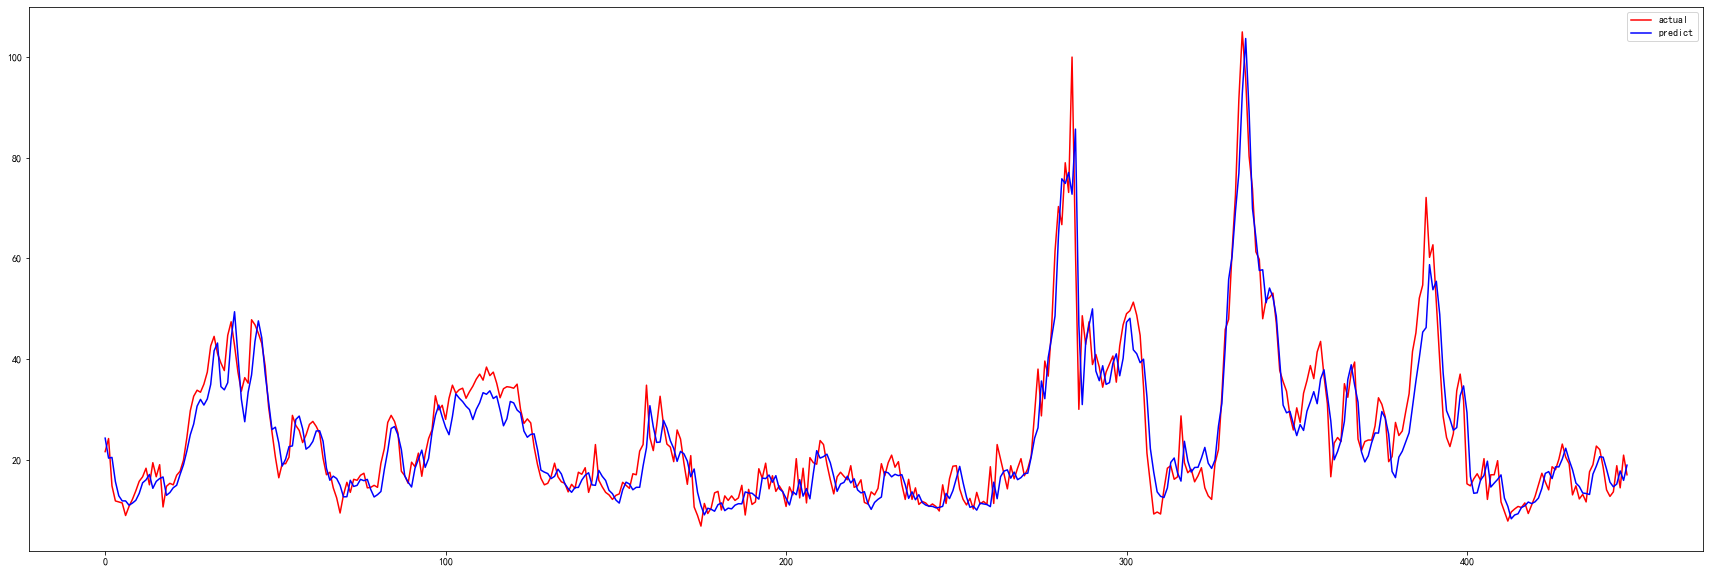

In [73]:
window = 30   # x 為歷史幾天天數
ntrain = int(len(df)*0.7)   # train, test 切分點
epo = 100
batch = 32
full_var = multi_LSTM(df[:ntrain], df[ntrain:], window, epo, batch)

## 沒有放天氣

In [76]:
df_now = df.drop(columns=['Temperature_n','Precp_n','Temperature_m','Precp_m','Temperature_s','Precp_s'])
df_now

,Upper_Price,Middle_Price,Lower_Price,Avg_Price,Trans_Quantity
0,14.0,9.9,3.8,9.5,6718.0
1,12.0,9.0,5.3,8.9,9143.0
2,12.1,8.4,3.2,8.1,8489.0
3,11.3,8.5,4.2,8.2,6457.0
4,11.0,7.8,3.1,7.5,7353.0
...,...,...,...,...,...
1488,23.0,13.6,4.8,13.7,4646.0
1489,26.2,18.8,8.4,18.2,4237.0
1490,23.4,14.4,5.3,14.4,5689.0
1491,35.1,20.9,6.1,20.8,4213.0


train_x_sc: 
(1045, 5)
train_y_sc: 
(1045, 1)
train shape: 
(1015, 30, 5) (1015,)
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 50)                11200     
_________________________________________________________________
dropout_21 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
32/32 [==============================] - 1s 6ms/step - loss: 0.0127
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0067
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0053
Epoch 4/100
32/32 [==============================] - 0s 5m

Epoch 92/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 93/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 94/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 95/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 96/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 97/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 98/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 99/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 100/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0022
full_test: 
(478, 5)
test after window: 
(448, 30, 5)
predict: 
(448, 1)
predict result: 
       predict
0    28.123976
1    23.430758
2    22.870792
3    16.798805
4    13.182135
..         ...
443  15.203135
444  14.765621
445  18.288803
446  16.449591
447  20.474051


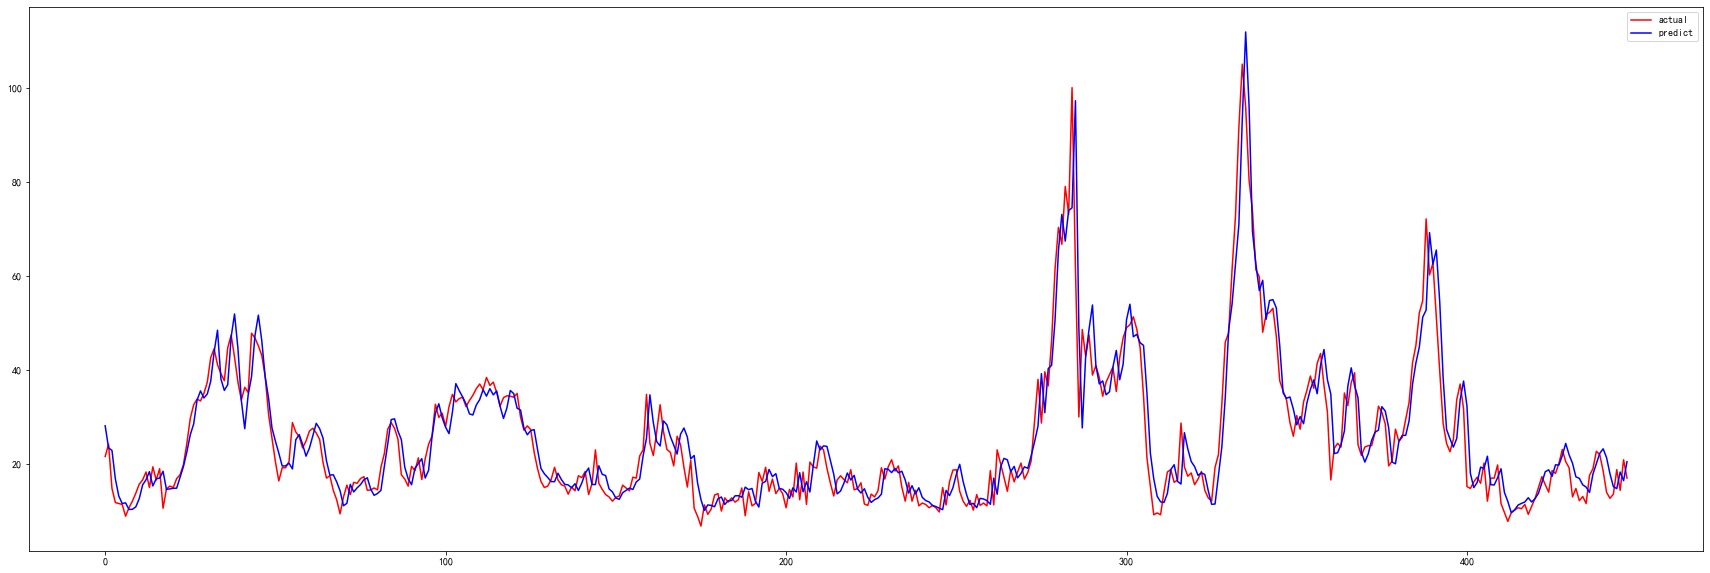

In [77]:
window = 30
epo = 100
batch = 32
ntrain = int(len(df)*0.7)
no_weather = multi_LSTM(df_now[:ntrain], df_now[ntrain:], window, epo, batch)

## 中價、交易量、天氣

In [78]:
df_noprice = df.drop(columns=['Upper_Price','Avg_Price','Lower_Price'])
df_noprice

,Middle_Price,Trans_Quantity,Temperature_n,Precp_n,Temperature_m,Precp_m,Temperature_s,Precp_s
0,9.9,6718.0,20.77,0.75,19.40,0.08,21.87,0.15
1,9.0,9143.0,20.45,3.20,20.00,0.33,22.33,0.00
2,8.4,8489.0,21.80,0.47,20.27,0.00,22.67,0.02
3,8.5,6457.0,21.03,0.00,20.50,0.00,22.78,0.00
4,7.8,7353.0,21.07,3.23,20.13,0.00,22.78,0.02
...,...,...,...,...,...,...,...,...
1488,13.6,4646.0,13.80,6.60,15.98,0.67,18.15,0.01
1489,18.8,4237.0,16.48,1.00,16.85,0.00,19.27,0.51
1490,14.4,5689.0,17.60,0.19,17.78,0.83,20.52,4.51
1491,20.9,4213.0,15.88,0.08,17.05,0.17,19.83,0.09


train_x_sc: 
(1045, 8)
train_y_sc: 
(1045, 1)
train shape: 
(1015, 30, 8) (1015,)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 50)                11800     
_________________________________________________________________
dropout_22 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
32/32 [==============================] - 1s 6ms/step - loss: 0.0292
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0116
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0085
Epoch 4/100
32/32 [==============================] - 0s 5

Epoch 92/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0022
Epoch 93/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 94/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 95/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 96/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0022
Epoch 97/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 98/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0020
Epoch 99/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 100/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0022
full_test: 
(478, 8)
test after window: 
(448, 30, 8)
predict: 
(448, 1)
predict result: 
       predict
0    26.154699
1    22.478745
2    21.408405
3    15.079306
4    11.805261
..         ...
443  13.636716
444  14.573108
445  17.443354
446  16.211182
447  19.230675


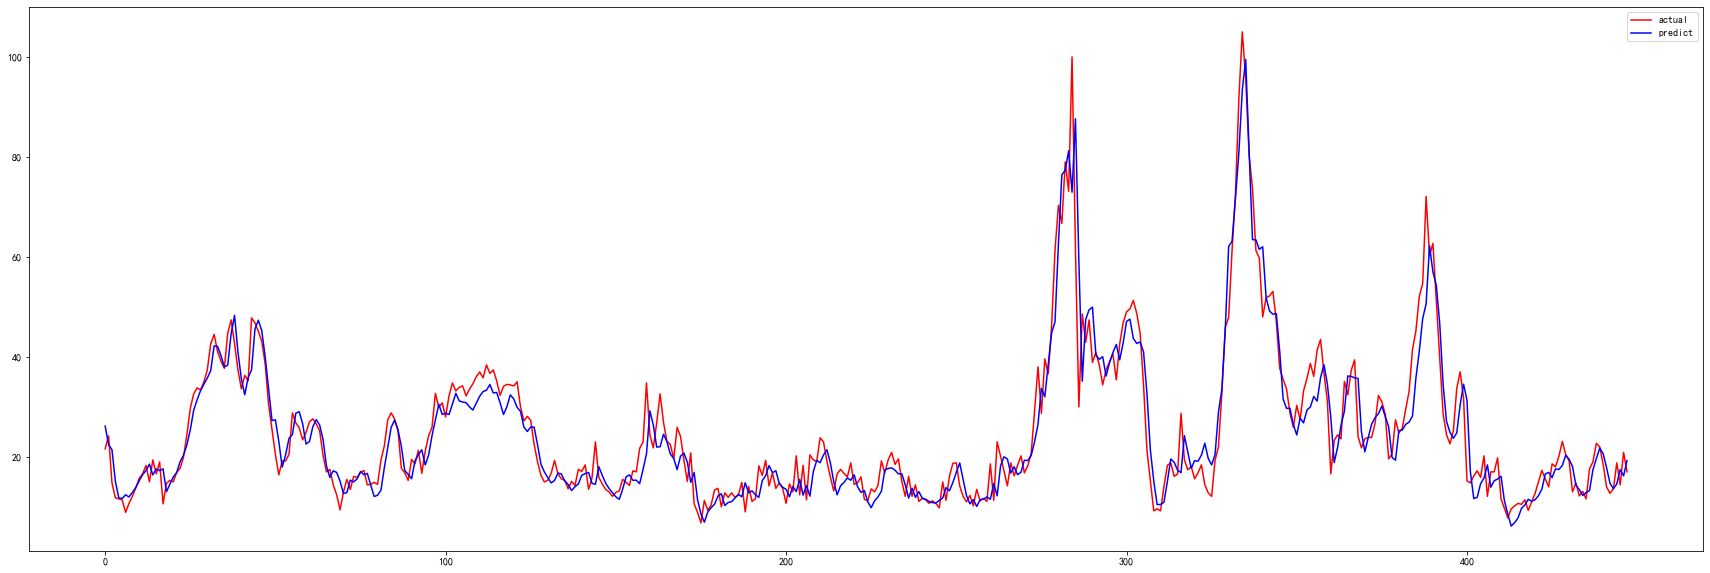

In [79]:
window = 30
epo = 100
batch = 32
ntrain = int(len(df)*0.7)
only_price_quant = multi_LSTM(df_noprice[:ntrain], df_noprice[ntrain:], window, epo, batch)

## 只有放中價、交易量

In [80]:
df_stand = df.drop(columns=['Upper_Price','Avg_Price','Lower_Price','Temperature_n','Precp_n','Temperature_m','Precp_m','Temperature_s','Precp_s'])
df_stand

,Middle_Price,Trans_Quantity
0,9.9,6718.0
1,9.0,9143.0
2,8.4,8489.0
3,8.5,6457.0
4,7.8,7353.0
...,...,...
1488,13.6,4646.0
1489,18.8,4237.0
1490,14.4,5689.0
1491,20.9,4213.0


train_x_sc: 
(1045, 2)
train_y_sc: 
(1045, 1)
train shape: 
(1015, 30, 2) (1015,)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 50)                10600     
_________________________________________________________________
dropout_23 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 10,651
Trainable params: 10,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
32/32 [==============================] - 1s 6ms/step - loss: 0.0187
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0088
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0069
Epoch 4/100
32/32 [==============================] - 0s 5

Epoch 92/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 93/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 94/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 95/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 96/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0025
Epoch 97/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 98/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 99/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 100/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0025
full_test: 
(478, 2)
test after window: 
(448, 30, 2)
predict: 
(448, 1)
predict result: 
       predict
0    28.967978
1    24.220100
2    23.241749
3    15.608169
4    11.779831
..         ...
443  14.071122
444  14.697718
445  18.966721
446  17.317879
447  20.761717


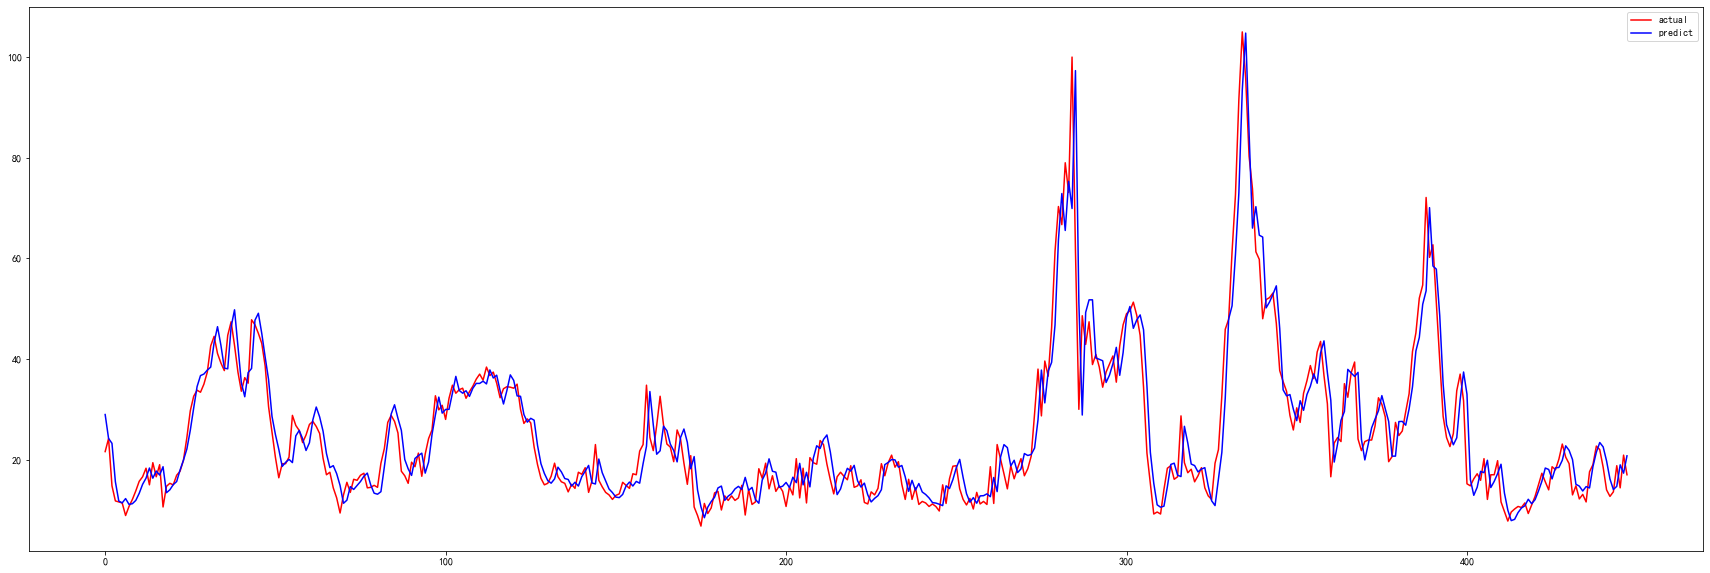

In [81]:
window = 30
epo = 100
batch = 32
ntrain = int(len(df)*0.7)
only_price_quant = multi_LSTM(df_stand[:ntrain], df_stand[ntrain:], window, epo, batch)

## 只有放中價

In [82]:
df_mid = df.drop(columns=['Upper_Price','Avg_Price','Lower_Price','Trans_Quantity','Temperature_n','Precp_n','Temperature_m','Precp_m','Temperature_s','Precp_s'])
df_mid

,Middle_Price
0,9.9
1,9.0
2,8.4
3,8.5
4,7.8
...,...
1488,13.6
1489,18.8
1490,14.4
1491,20.9


train_x_sc: 
(1045, 1)
train_y_sc: 
(1045, 1)
train shape: 
(1015, 30, 1) (1015,)
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dropout_24 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
32/32 [==============================] - 1s 5ms/step - loss: 0.0183
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0103
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0081
Epoch 4/100
32/32 [==============================] - 0s 5

Epoch 92/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 93/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 94/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 95/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 96/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0027
Epoch 97/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 98/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 99/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 100/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0027
full_test: 
(478, 1)
test after window: 
(448, 30, 1)
predict: 
(448, 1)
predict result: 
       predict
0    28.396338
1    22.275768
2    23.530067
3    16.332933
4    12.215303
..         ...
443  12.797708
444  13.548018
445  18.390785
446  16.671856
447  20.679718


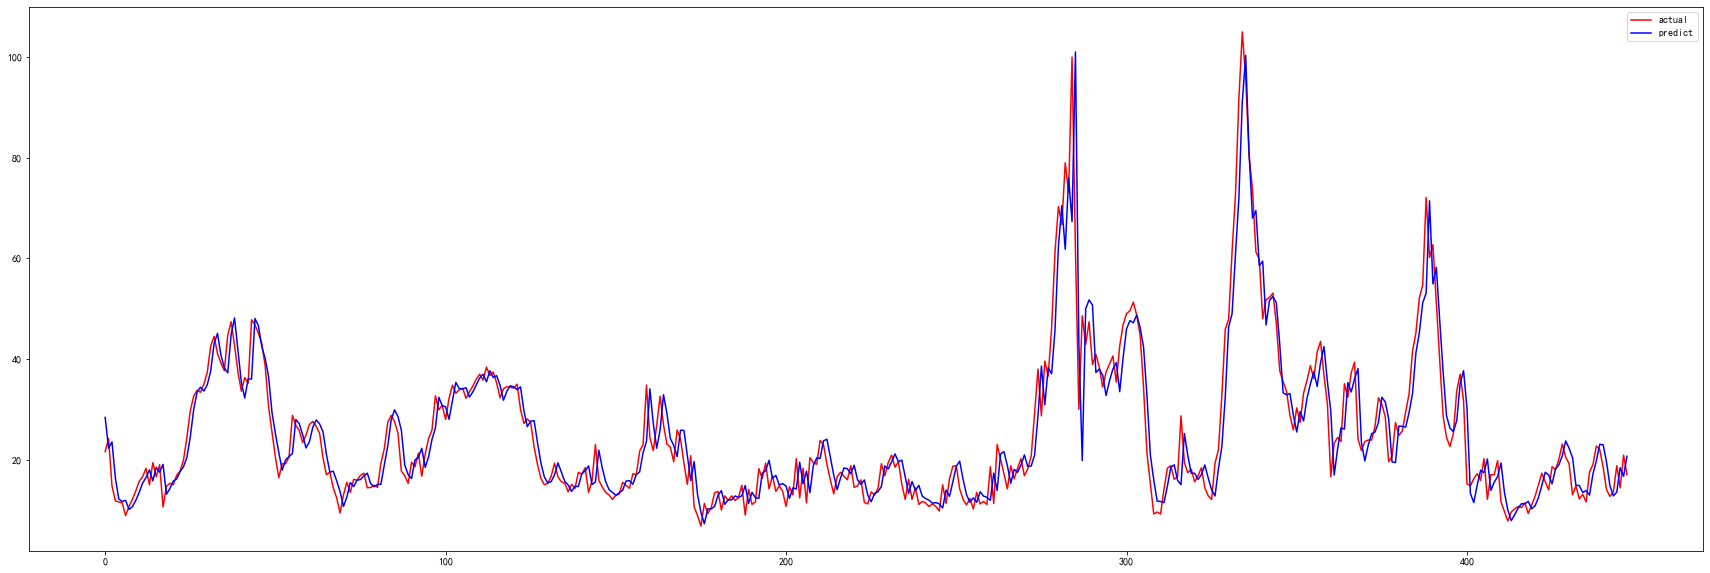

In [83]:
window = 30
epo = 100
batch = 32
ntrain = int(len(df)*0.7)
only_mid = multi_LSTM(df_mid[:ntrain], df_mid[ntrain:], window, epo, batch)

# Multi LSTM function

In [14]:
def mape(y_true,y_predict): # 計算 MAPE
    return np.mean(np.abs((y_true-y_predict)/y_true)) * 100

In [15]:
def plot_history(history): # 畫出 train, validation loss 的圖
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## Multi LSTM

In [84]:
##### 多變量 LSTM (Baseline)#####
### 預測未來一天
### 這個函式的 y 寫死是 'Middle Price'，可以加 target_name 參數進去改成可變動的 y
# df_train: 切好的訓練部分，包含 x,y
# df_test: 切好的訓練部分，包含 x,y
# window: x 的歷史天數
# epo: epoch 數量
# batch: batch 大小

#################################

def multi_LSTM(df_train, df_test, window, epo, batch):
    # normalization
    sc = MinMaxScaler(feature_range=(0, 1))
    df_train_sc = sc.fit_transform(df_train)
    features = df_train_sc.shape[1]
    print("train_x_sc: ")
    print(df_train_sc.shape)
    sc2 = MinMaxScaler(feature_range=(0, 1))
    df_train_sc_y = sc2.fit_transform(df_train[['Middle_Price']]) # train_y cut from window
    print("train_y_sc: ")
    print(df_train_sc_y.shape)
    
    # process moving window
    X_train = []
    Y_train = []
    for i in range(window,len(df_train)):
        X_train.append(df_train_sc[i-window:i])
        Y_train.append(df_train_sc_y[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
    print("train shape: ")
    print(X_train.shape,Y_train.shape)
    
    # training
    set_rand()
    model = Sequential()
#     model.add(LSTM(units=50,return_sequences=True,input_shape=(window,features))) #(30d,6features)
#     model.add(Dropout(0.2))
    model.add(LSTM(units=50,input_shape=(window,features)))
    model.add(Dropout(0.2))
#     model.add(Dense(24))
    model.add(Dense(1))
    model.compile(optimizer='adam',loss="mean_squared_error")
    model.summary()
    model.fit(X_train,Y_train,epochs=epo,batch_size=batch)
    
    # process test set (x)
    df_train_last = df_train[-1*window:]
    full_test = pd.concat((df_train_last,df_test),axis=0)
    full_test = sc.transform(full_test)
    print("full_test: ")
    print(full_test.shape)
    
    record_num = full_test.shape[0]
    X_test = []
    for i in range(window,record_num): #30,478
        X_test.append(full_test[i-window:i])
    X_test = np.array(X_test)
    print("test after window: ")
    print(X_test.shape)
    
    # predict
    Y_test = model.predict(X_test)
    print("predict: ")
    print(Y_test.shape)
    y_pred = sc2.inverse_transform(Y_test)
    final_predict = pd.DataFrame(y_pred)
    final_predict.columns=['predict']
    print("predict result: ")
    print(final_predict)
    final_predict.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    match = pd.concat((final_predict,df_test),axis=1)
    
    # plot the result
    plt.figure(figsize=(30,10))
    plt.plot(match['Middle_Price'],label='actual',color='red')
    plt.plot(match['predict'],label='predict',color='blue')
    plt.legend()
    
    # metrics
    # calculate MAE
    mae = mean_absolute_error(match['Middle_Price'], match['predict'])
    # calculate MSE
    mse = mean_squared_error(match['Middle_Price'], match['predict'])
    rmse = np.sqrt(mse)

    # display
    print("Mean absolute error : " + str(mae))
    print("Mean squared error : " + str(mse))
    print("Root Mean squared error : " + str(rmse))
    print("Mean Absolute Percentage Error : " + str(mape(match['Middle_Price'],match['predict'])))
    
    return model, sc, sc2

### use Functional API

驗證固定 random seed 的情況下，使用 functional API 跑出來結果與先前一樣。
這一個 API 是不放外生變數，預測未來一天
跟上面那個 multi_LSTM 一樣，只是使用不同 API 寫的。

In [1051]:
 def multi_LSTM_functional(df_train, df_test, window, epo, batch):
    # normalization
    sc = MinMaxScaler(feature_range=(0, 1))
    df_train_sc = sc.fit_transform(df_train)
    features = df_train_sc.shape[1]
    print("train_x_sc: ")
    print(df_train_sc.shape)
    sc2 = MinMaxScaler(feature_range=(0, 1))
    df_train_sc_y = sc2.fit_transform(df_train[['Middle_Price']]) # train_y cut from window
    print("train_y_sc: ")
    print(df_train_sc_y.shape)
    
    # process moving window
    X_train = []
    Y_train = []
    for i in range(window,len(df_train)):
        X_train.append(df_train_sc[i-window:i])
        Y_train.append(df_train_sc_y[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
    print("train shape: ")
    print(X_train.shape,Y_train.shape)
    
    # model and training
    set_rand()
    ## first LSTM model
    input1 = Input(shape=(window,features,), name="original_input")
    lstm_output = LSTM(units=50)(input1)
    lstm_output = layers.Dropout(0.2)(lstm_output)
    final_pred = Dense(1, name="final_dense")(lstm_output)
    ## create the model
    model = Model(inputs=input1, outputs=final_pred)
    model.summary()
    
    # train
    opt = Adam(learning_rate = lr)
    es = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
#     callback = [early_stopping]
    mc = ModelCheckpoint('../iris/Model/best_model.h5', monitor='val_loss', verbose=1, save_best_only=True)
    
    model.compile(optimizer=opt, loss="mean_squared_error")
    history = model.fit(X_train, Y_train, validation_split=0.1, epochs=epo, batch_size=batch, callbacks=[es, mc])
#     model.compile(optimizer='adam',loss="mean_squared_error")
#     model.fit(X_train, Y_train, epochs=epo, batch_size=batch)
    plot_history(history)
    # load the saved model
    saved_model = load_model('../iris/Model/best_model.h5')
    
    # process test set (x)
    df_train_last = df_train[-1*window:]
    full_test = pd.concat((df_train_last,df_test),axis=0)
    full_test = sc.transform(full_test)
    print("full_test: ")
    print(full_test.shape)
    
    record_num = full_test.shape[0]
    X_test = []
    for i in range(window,record_num): #30,478
        X_test.append(full_test[i-window:i])
    X_test = np.array(X_test)
    print("test after window: ")
    print(X_test.shape)
    
    # predict
    Y_test = saved_model.predict(X_test)
    print("predict: ")
    print(Y_test.shape)
    y_pred = sc2.inverse_transform(Y_test)
    final_predict = pd.DataFrame(y_pred)
    final_predict.columns=['predict']
    print("predict result: ")
    print(final_predict)
    final_predict.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    match = pd.concat((final_predict,df_test),axis=1)
    
    # plot the result
    plt.figure(figsize=(30,10))
    plt.plot(match['Middle_Price'],label='actual',color='red')
    plt.plot(match['predict'],label='predict',color='blue')
    plt.legend()
    
    # metrics
    # calculate MAE
    mae = mean_absolute_error(match['Middle_Price'], match['predict'])
    # calculate MSE
    mse = mean_squared_error(match['Middle_Price'], match['predict'])
    rmse = np.sqrt(mse)

    # display
    print("Mean absolute error : " + str(mae))
    print("Mean squared error : " + str(mse))
    print("Root Mean squared error : " + str(rmse))
    print("Mean Absolute Percentage Error : " + str(mape(match['Middle_Price'],match['predict'])))
    
    return model, sc, sc2

train_x_sc: 
(1194, 11)
train_y_sc: 
(1194, 1)
train shape: 
(1164, 30, 11) (1164,)
Model: "model_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_input (InputLayer)  [(None, 30, 11)]          0         
_________________________________________________________________
lstm_106 (LSTM)              (None, 50)                12400     
_________________________________________________________________
dropout_65 (Dropout)         (None, 50)                0         
_________________________________________________________________
final_dense (Dense)          (None, 1)                 51        
Total params: 12,451
Trainable params: 12,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
33/33 [==============================] - 3s 35ms/step - loss: 0.0307 - val_loss: 0.0048

Epoch 00001: val_loss improved from inf to 0.00481, saving model to

Epoch 43/100
33/33 [==============================] - 1s 15ms/step - loss: 0.0024 - val_loss: 0.0018

Epoch 00043: val_loss did not improve from 0.00145
Epoch 44/100
33/33 [==============================] - 0s 14ms/step - loss: 0.0022 - val_loss: 0.0015

Epoch 00044: val_loss did not improve from 0.00145
Epoch 45/100
33/33 [==============================] - 1s 18ms/step - loss: 0.0023 - val_loss: 0.0014

Epoch 00045: val_loss improved from 0.00145 to 0.00144, saving model to ../iris/Model/best_model.h5
Epoch 46/100
33/33 [==============================] - 0s 14ms/step - loss: 0.0024 - val_loss: 0.0014

Epoch 00046: val_loss improved from 0.00144 to 0.00144, saving model to ../iris/Model/best_model.h5
Epoch 47/100
33/33 [==============================] - 1s 16ms/step - loss: 0.0023 - val_loss: 0.0014

Epoch 00047: val_loss improved from 0.00144 to 0.00140, saving model to ../iris/Model/best_model.h5
Epoch 48/100
33/33 [==============================] - 1s 15ms/step - loss: 0.0020 - val_

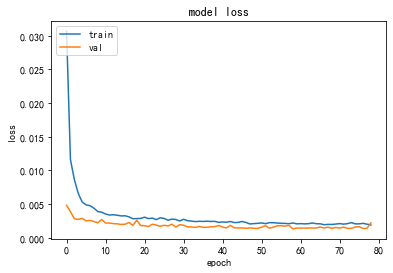

full_test: 
(329, 11)
test after window: 
(299, 30, 11)
predict: 
(299, 1)
predict result: 
       predict
0    14.023996
1    12.660748
2    11.988691
3    14.505416
4    15.894266
..         ...
294  15.105338
295  15.717441
296  18.515343
297  16.518682
298  19.626579

[299 rows x 1 columns]
Mean absolute error : 3.949268330857905
Mean squared error : 30.453738903424522
Root Mean squared error : 5.518490636344735
Mean Absolute Percentage Error : 17.643538345225835


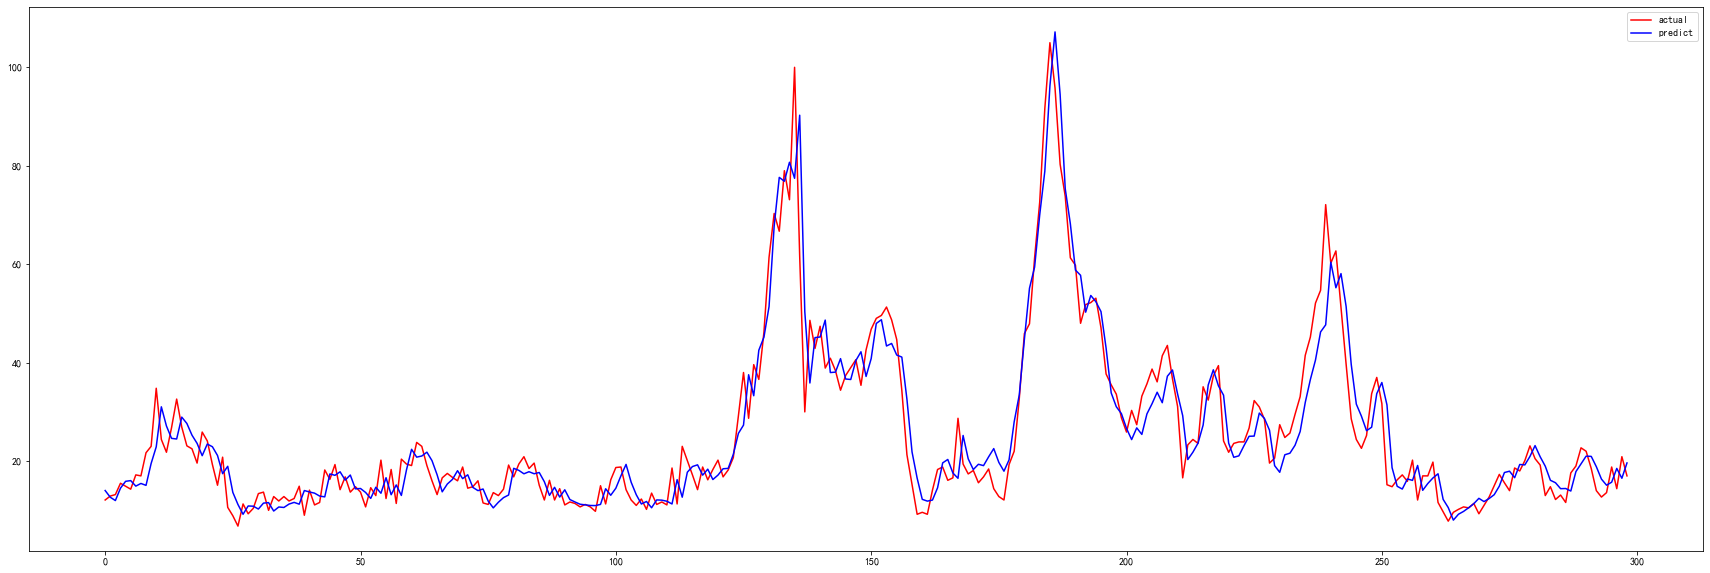

In [1148]:
# 變數全放
window = 30
features = 11
ntrain = int(len(df)*0.8)
epo = 100
batch = 32
full_var = multi_LSTM_functional(df[:ntrain], df[ntrain:], window, epo, batch)

train_x_sc: 
(1194, 5)
train_y_sc: 
(1194, 1)
train shape: 
(1164, 30, 5) (1164,)
Model: "model_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_input (InputLayer)  [(None, 30, 5)]           0         
_________________________________________________________________
lstm_107 (LSTM)              (None, 50)                11200     
_________________________________________________________________
dropout_66 (Dropout)         (None, 50)                0         
_________________________________________________________________
final_dense (Dense)          (None, 1)                 51        
Total params: 11,251
Trainable params: 11,251
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
33/33 [==============================] - 3s 26ms/step - loss: 0.0120 - val_loss: 0.0035

Epoch 00001: val_loss improved from inf to 0.00354, saving model to .

Epoch 41/100
33/33 [==============================] - 1s 15ms/step - loss: 0.0024 - val_loss: 0.0014

Epoch 00041: val_loss did not improve from 0.00133
Epoch 42/100
33/33 [==============================] - 0s 14ms/step - loss: 0.0023 - val_loss: 0.0014

Epoch 00042: val_loss did not improve from 0.00133
Epoch 43/100
33/33 [==============================] - 0s 13ms/step - loss: 0.0025 - val_loss: 0.0014

Epoch 00043: val_loss did not improve from 0.00133
Epoch 44/100
33/33 [==============================] - 0s 12ms/step - loss: 0.0024 - val_loss: 0.0014

Epoch 00044: val_loss did not improve from 0.00133
Epoch 45/100
33/33 [==============================] - 0s 13ms/step - loss: 0.0024 - val_loss: 0.0013

Epoch 00045: val_loss did not improve from 0.00133
Epoch 46/100
33/33 [==============================] - 0s 15ms/step - loss: 0.0024 - val_loss: 0.0013

Epoch 00046: val_loss did not improve from 0.00133
Epoch 47/100
33/33 [==============================] - 1s 16ms/step - loss: 0.0023 

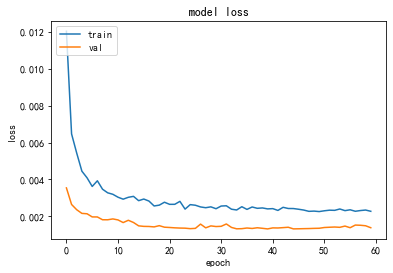

full_test: 
(329, 5)
test after window: 
(299, 30, 5)
predict: 
(299, 1)
predict result: 
       predict
0    14.305945
1    12.845376
2    12.535879
3    14.295282
4    14.661215
..         ...
294  15.213018
295  15.183032
296  18.665306
297  16.378387
298  20.545874

[299 rows x 1 columns]
Mean absolute error : 4.177304644249753
Mean squared error : 35.63519792005365
Root Mean squared error : 5.969522419763046
Mean Absolute Percentage Error : 18.935201691130814


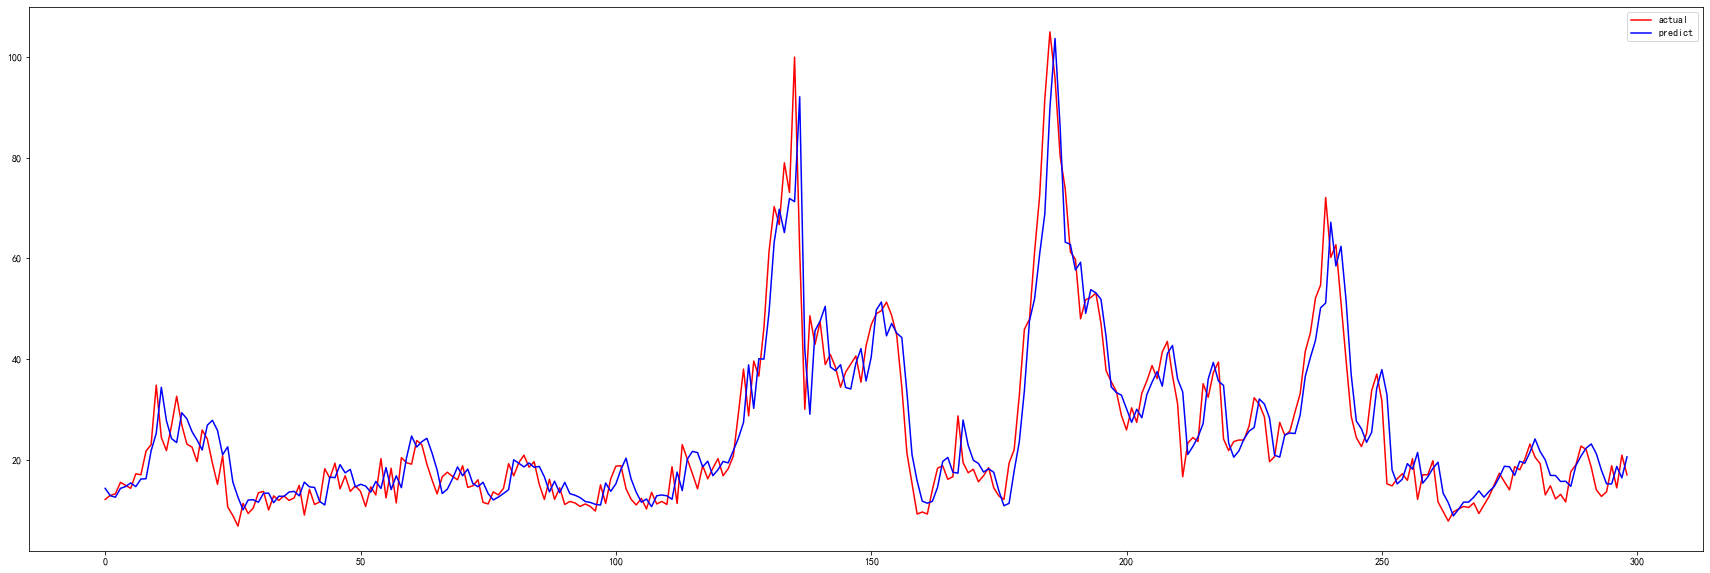

In [1149]:
df_now = df.drop(columns=['Temperature_n','Precp_n','Temperature_m','Precp_m','Temperature_s','Precp_s'])
no_weather = multi_LSTM_functional(df_now[:ntrain], df_now[ntrain:], window, epo, batch)

train_x_sc: 
(1194, 8)
train_y_sc: 
(1194, 1)
train shape: 
(1164, 30, 8) (1164,)
Model: "model_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_input (InputLayer)  [(None, 30, 8)]           0         
_________________________________________________________________
lstm_94 (LSTM)               (None, 50)                11800     
_________________________________________________________________
dropout_53 (Dropout)         (None, 50)                0         
_________________________________________________________________
final_dense (Dense)          (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
33/33 [==============================] - 3s 32ms/step - loss: 0.0273 - val_loss: 0.0072

Epoch 00001: val_loss improved from inf to 0.00717, saving model to .


Epoch 00041: val_loss did not improve from 0.00168
Epoch 42/100
33/33 [==============================] - 0s 11ms/step - loss: 0.0029 - val_loss: 0.0016

Epoch 00042: val_loss improved from 0.00168 to 0.00160, saving model to ../iris/Model/best_model.h5
Epoch 43/100
33/33 [==============================] - 0s 12ms/step - loss: 0.0028 - val_loss: 0.0016

Epoch 00043: val_loss improved from 0.00160 to 0.00158, saving model to ../iris/Model/best_model.h5
Epoch 44/100
33/33 [==============================] - 0s 14ms/step - loss: 0.0028 - val_loss: 0.0017

Epoch 00044: val_loss did not improve from 0.00158
Epoch 45/100
33/33 [==============================] - 0s 13ms/step - loss: 0.0028 - val_loss: 0.0015

Epoch 00045: val_loss improved from 0.00158 to 0.00154, saving model to ../iris/Model/best_model.h5
Epoch 46/100
33/33 [==============================] - 0s 15ms/step - loss: 0.0029 - val_loss: 0.0017

Epoch 00046: val_loss did not improve from 0.00154
Epoch 47/100
33/33 [================

33/33 [==============================] - 0s 13ms/step - loss: 0.0022 - val_loss: 0.0012

Epoch 00091: val_loss did not improve from 0.00114
Epoch 92/100
33/33 [==============================] - 0s 13ms/step - loss: 0.0021 - val_loss: 0.0017

Epoch 00092: val_loss did not improve from 0.00114
Epoch 93/100
33/33 [==============================] - 0s 15ms/step - loss: 0.0021 - val_loss: 0.0014

Epoch 00093: val_loss did not improve from 0.00114
Epoch 94/100
33/33 [==============================] - 0s 15ms/step - loss: 0.0021 - val_loss: 0.0013

Epoch 00094: val_loss did not improve from 0.00114
Epoch 95/100
33/33 [==============================] - 0s 15ms/step - loss: 0.0021 - val_loss: 0.0012

Epoch 00095: val_loss did not improve from 0.00114
Epoch 96/100
33/33 [==============================] - 1s 15ms/step - loss: 0.0022 - val_loss: 0.0012

Epoch 00096: val_loss did not improve from 0.00114
Epoch 97/100
33/33 [==============================] - 1s 16ms/step - loss: 0.0022 - val_loss: 0

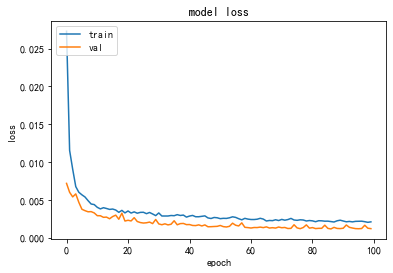

full_test: 
(329, 8)
test after window: 
(299, 30, 8)
predict: 
(299, 1)
predict result: 
       predict
0    14.101192
1    13.223232
2    12.713944
3    14.985343
4    17.440805
..         ...
294  14.688988
295  15.690733
296  18.380789
297  17.045456
298  20.098225

[299 rows x 1 columns]
Mean absolute error : 3.8156268776858533
Mean squared error : 30.9069788414542
Root Mean squared error : 5.559404540187213
Mean Absolute Percentage Error : 16.927702711019762


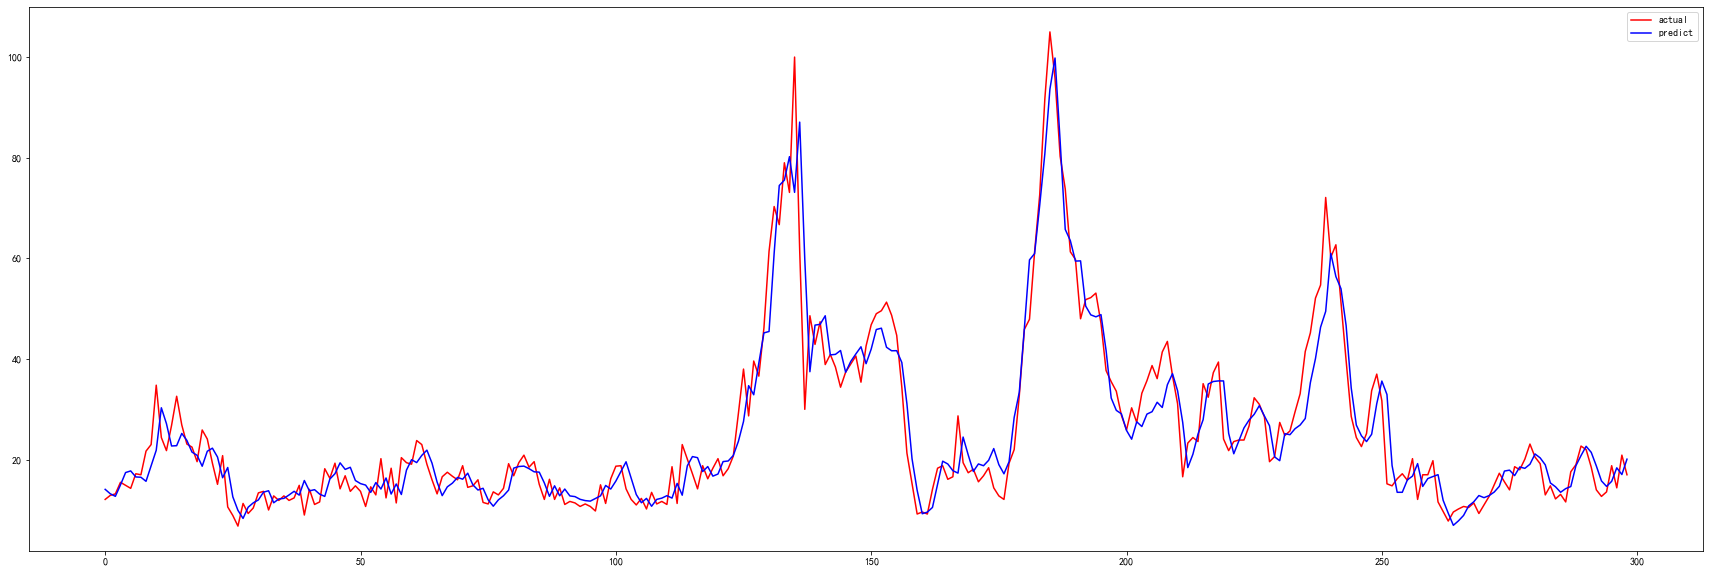

In [1060]:
df_noprice = df.drop(columns=['Upper_Price','Avg_Price','Lower_Price'])
window = 30
epo = 100
batch = 32
ntrain = int(len(df)*0.8)
lr = 0.001
only_price_quant = multi_LSTM_functional(df_noprice[:ntrain], df_noprice[ntrain:], window, epo, batch)

train_x_sc: 
(1194, 2)
train_y_sc: 
(1194, 1)
train shape: 
(1164, 30, 2) (1164,)
Model: "model_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_input (InputLayer)  [(None, 30, 2)]           0         
_________________________________________________________________
lstm_108 (LSTM)              (None, 50)                10600     
_________________________________________________________________
dropout_67 (Dropout)         (None, 50)                0         
_________________________________________________________________
final_dense (Dense)          (None, 1)                 51        
Total params: 10,651
Trainable params: 10,651
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
33/33 [==============================] - 4s 36ms/step - loss: 0.0171 - val_loss: 0.0046

Epoch 00001: val_loss improved from inf to 0.00461, saving model to .

33/33 [==============================] - 0s 14ms/step - loss: 0.0027 - val_loss: 0.0014

Epoch 00040: val_loss did not improve from 0.00134
Epoch 41/100
33/33 [==============================] - 1s 17ms/step - loss: 0.0028 - val_loss: 0.0015

Epoch 00041: val_loss did not improve from 0.00134
Epoch 42/100
33/33 [==============================] - 0s 15ms/step - loss: 0.0028 - val_loss: 0.0014

Epoch 00042: val_loss did not improve from 0.00134
Epoch 43/100
33/33 [==============================] - 0s 15ms/step - loss: 0.0028 - val_loss: 0.0015

Epoch 00043: val_loss did not improve from 0.00134
Epoch 44/100
33/33 [==============================] - 0s 15ms/step - loss: 0.0028 - val_loss: 0.0014

Epoch 00044: val_loss did not improve from 0.00134
Epoch 45/100
33/33 [==============================] - 0s 15ms/step - loss: 0.0028 - val_loss: 0.0013

Epoch 00045: val_loss improved from 0.00134 to 0.00131, saving model to ../iris/Model/best_model.h5
Epoch 46/100
33/33 [==========================

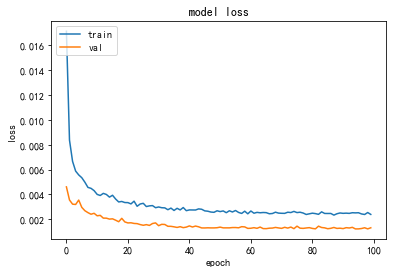

full_test: 
(329, 2)
test after window: 
(299, 30, 2)
predict: 
(299, 1)
predict result: 
       predict
0    13.574856
1    12.763254
2    12.741311
3    13.465094
4    15.224843
..         ...
294  13.775160
295  14.531293
296  18.957031
297  17.247009
298  20.717428

[299 rows x 1 columns]
Mean absolute error : 4.20187205885565
Mean squared error : 37.69150167750307
Root Mean squared error : 6.139340492064524
Mean Absolute Percentage Error : 18.379686280030956


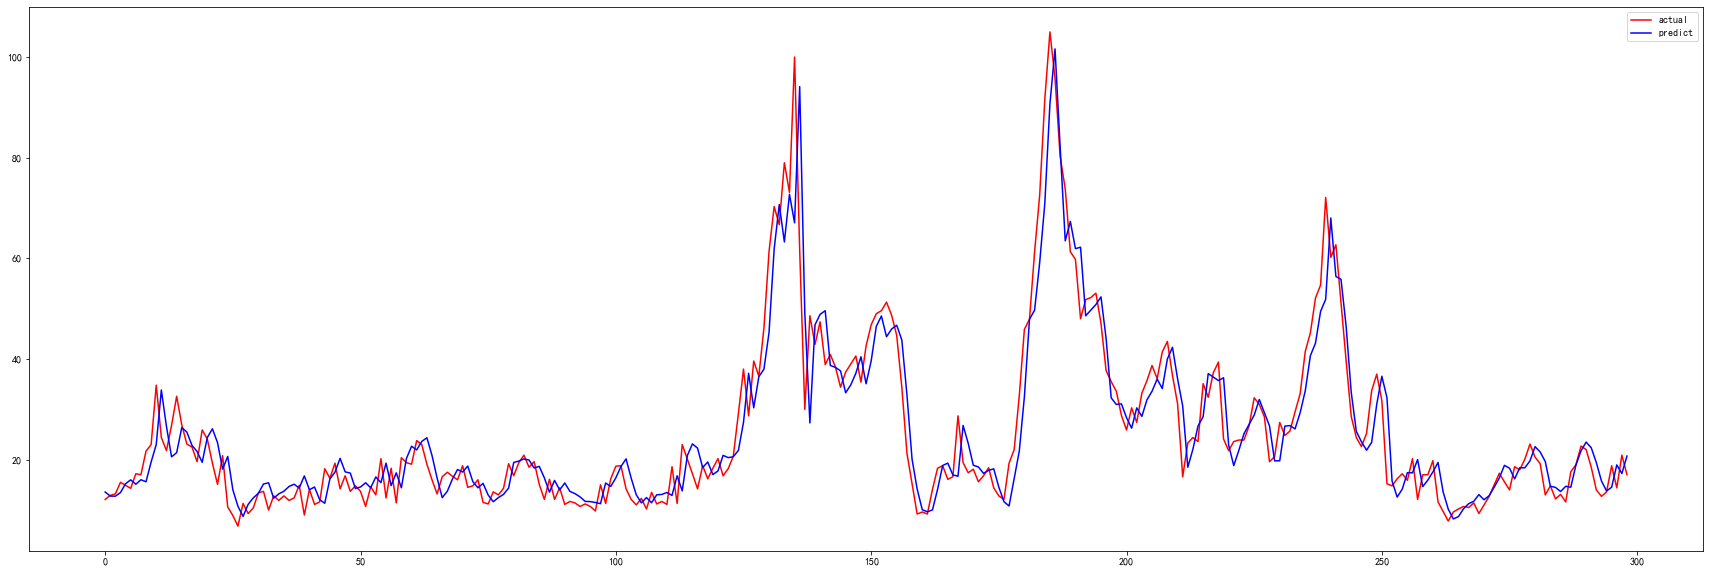

In [1150]:
# 只放中價、交易量
df_stand = df.drop(columns=['Upper_Price','Avg_Price','Lower_Price','Temperature_n','Precp_n','Temperature_m','Precp_m','Temperature_s','Precp_s'])
only_price_quant = multi_LSTM_functional(df_stand[:ntrain], df_stand[ntrain:], window, epo, batch)

train_x_sc: 
(1194, 1)
train_y_sc: 
(1194, 1)
train shape: 
(1164, 30, 1) (1164,)
Model: "model_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_input (InputLayer)  [(None, 30, 1)]           0         
_________________________________________________________________
lstm_109 (LSTM)              (None, 50)                10400     
_________________________________________________________________
dropout_68 (Dropout)         (None, 50)                0         
_________________________________________________________________
final_dense (Dense)          (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
33/33 [==============================] - 3s 32ms/step - loss: 0.0162 - val_loss: 0.0057

Epoch 00001: val_loss improved from inf to 0.00569, saving model to .

33/33 [==============================] - 1s 15ms/step - loss: 0.0028 - val_loss: 0.0013

Epoch 00040: val_loss did not improve from 0.00129
Epoch 41/100
33/33 [==============================] - 0s 14ms/step - loss: 0.0028 - val_loss: 0.0014

Epoch 00041: val_loss did not improve from 0.00129
Epoch 42/100
33/33 [==============================] - 0s 13ms/step - loss: 0.0027 - val_loss: 0.0013

Epoch 00042: val_loss did not improve from 0.00129
Epoch 43/100
33/33 [==============================] - 0s 12ms/step - loss: 0.0028 - val_loss: 0.0013

Epoch 00043: val_loss improved from 0.00129 to 0.00127, saving model to ../iris/Model/best_model.h5
Epoch 44/100
33/33 [==============================] - 0s 13ms/step - loss: 0.0028 - val_loss: 0.0014

Epoch 00044: val_loss did not improve from 0.00127
Epoch 45/100
33/33 [==============================] - 0s 14ms/step - loss: 0.0028 - val_loss: 0.0013

Epoch 00045: val_loss improved from 0.00127 to 0.00126, saving model to ../iris/Model/best_model.

33/33 [==============================] - 0s 15ms/step - loss: 0.0026 - val_loss: 0.0013

Epoch 00090: val_loss did not improve from 0.00121
Epoch 91/100
33/33 [==============================] - 0s 13ms/step - loss: 0.0026 - val_loss: 0.0012

Epoch 00091: val_loss did not improve from 0.00121
Epoch 92/100
33/33 [==============================] - 0s 12ms/step - loss: 0.0027 - val_loss: 0.0013

Epoch 00092: val_loss did not improve from 0.00121
Epoch 93/100
33/33 [==============================] - 0s 14ms/step - loss: 0.0026 - val_loss: 0.0012

Epoch 00093: val_loss did not improve from 0.00121
Epoch 94/100
33/33 [==============================] - 0s 13ms/step - loss: 0.0026 - val_loss: 0.0013

Epoch 00094: val_loss did not improve from 0.00121
Epoch 95/100
33/33 [==============================] - 0s 13ms/step - loss: 0.0026 - val_loss: 0.0012

Epoch 00095: val_loss did not improve from 0.00121
Epoch 96/100
33/33 [==============================] - 0s 12ms/step - loss: 0.0027 - val_loss: 0

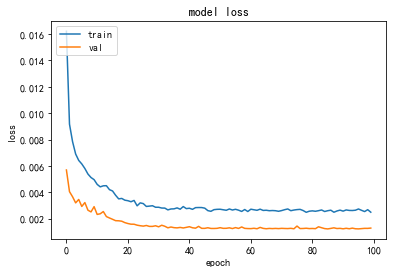

full_test: 
(329, 1)
test after window: 
(299, 30, 1)
predict: 
(299, 1)
predict result: 
       predict
0    13.351193
1    12.801824
2    13.371451
3    13.897792
4    15.774427
..         ...
294  12.638315
295  13.356321
296  18.208408
297  16.625582
298  20.605127

[299 rows x 1 columns]
Mean absolute error : 4.222426080863213
Mean squared error : 38.922996837845126
Root Mean squared error : 6.238829765095785
Mean Absolute Percentage Error : 18.08762042634018


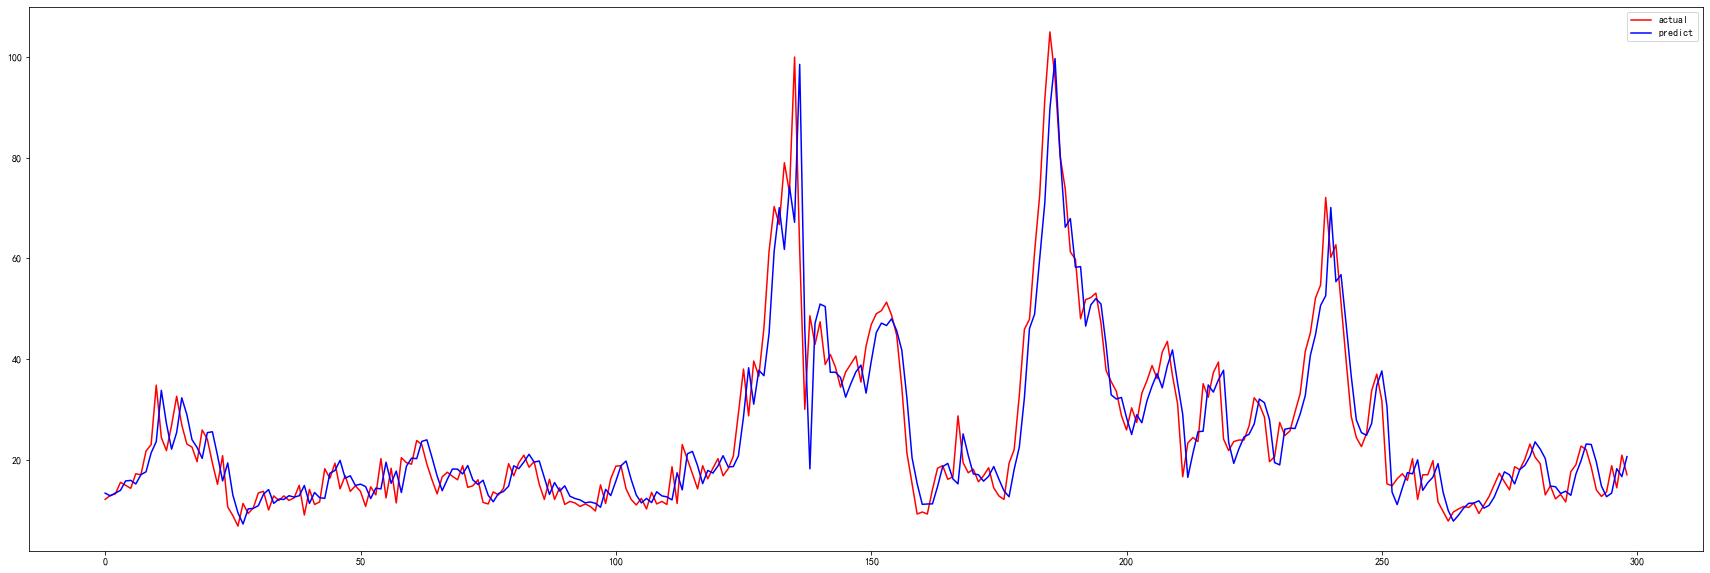

In [1151]:
# 只放中價
df_mid = df.drop(columns=['Upper_Price','Avg_Price','Lower_Price','Trans_Quantity','Temperature_n','Precp_n','Temperature_m','Precp_m','Temperature_s','Precp_s'])
only_mid = multi_LSTM_functional(df_mid[:ntrain], df_mid[ntrain:], window, epo, batch)

## LSTM with exogs

因為中間要加入外生變數的關係，必須改用 keras functional API

In [85]:
##### 多變量 LSTM + 外生變數 #####
### 在FC前加入外生變數，並預測未來多天

# df_train: 切好的訓練部分，包含 x,y
# df_test: 切好的訓練部分，包含 x,y
# df_exogs: 不用切，完整的所有外生變數
# window: x 的歷史天數
# future_d: 外生變數天數，如果不用外生變數，記得還是要設為0
# output_d: 最終預測未來天數
# epo: epoch 數量
# batch: batch 大小
# target_name: y 的欄位名稱
# use_valid: default=False。是否使用 validation set，若 True 會從訓練資料切最後 10% 去用(記得訓練資料改成 0.8)，且會選擇訓練過程中 val_loss 最低的模型儲存 checkpoint。
# cp_path: 模型 checkpoint 儲存路徑。default 為 ''，所以如果 use_valid = True 記得要指定路徑。 e.g.'../iris/Model'
# have_exogs: default = True。是否在 FC 前加入外生變數。
# lr: learning rate, default = 0.001。可調整可能對表現有蠻大影響。

################################# 

def multi_LSTM_exogs(df_train, df_test, df_exogs, window, future_d, output_d, epo, batch, target_name, use_valid=False, cp_path='', have_exogs=True, lr=0.001):
    # need to complete y_train and exogs_train with 5-1=4 instances from test set
    # 或者是傳入 df_train_y 時處理好去掉前30天加上後5天
    # 因為 train 要預測的最後一筆是 1045~1049, 1045 已有->只要多補4天
    df_train_y = pd.concat((df_train[[target_name]][window:],df_test[[target_name]][:output_d-1]),axis=0)
    # 現在 df_train_y 第0筆其實是第31天！！
    
    # normalization
    # scale x
    sc = MinMaxScaler(feature_range=(0, 1))
    df_train_sc = sc.fit_transform(df_train)
    features = df_train_sc.shape[1]
    print("train_sc_x: ")
    print(df_train_sc.shape)

    # scale y
    sc2 = MinMaxScaler(feature_range=(0, 1))
    df_train_sc_y = sc2.fit_transform(df_train_y)
    print("train_sc_y: ")
    print(df_train_sc_y.shape)
    
    # process moving window
    X_train = []
    Y_train = []
    for i in range(window,len(df_train)):
        X_train.append(df_train_sc[i-window:i])
    for i in range(len(df_train)-window):
        Y_train.append(df_train_sc_y[i:i+output_d,0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    print("train shape: ")
    print(X_train.shape,Y_train.shape)
    # print(Y_train)

    # process moving window for exogs
    # df_exogs 須先處理好為第window天開始的資料, 包含train,test部分
    # df_exogs = df.drop(columns=['Upper_Price','Middle_Price','Avg_Price','Lower_Price','Trans_Quantity'])
    if have_exogs:
        exogs_num = len(df_exogs.columns)
        Exogs_train = []
        # use new sc to fit and transform exogs
        sc_exogs = MinMaxScaler(feature_range=(0, 1))
        df_exogs_sc = sc_exogs.fit_transform(df_exogs[window:len(df_train)+future_d-1])
        for i in range(len(df_train)-window):
            Exogs_train.append(df_exogs_sc[i:i+future_d])
        Exogs_train = np.array(Exogs_train)
        print("exogs original shape: ")
        print(Exogs_train.shape)

        Exogs_train = Exogs_train.reshape(Exogs_train.shape[0],exogs_num*future_d) # flatten
        print("exogs concat shape: ")
        print(Exogs_train.shape)
    
    # model with exogs
    set_rand()
    ## first LSTM model
    input1 = Input(shape=(window,features,), name="original_input")
    lstm_output = LSTM(units=50)(input1)
    lstm_output = layers.Dropout(0.2)(lstm_output)
    
    if have_exogs:
        ## intermidate input (exogs)
        input2 = Input(shape=(exogs_num*future_d,), name="exogs_input")
        ## concat firt LSTM output & exogs
        final_merged = layers.concatenate([lstm_output, input2])
        final_pred = Dense(output_d, name="final_dense")(final_merged) # output dimension output_d
        ## create the model
        model = Model(inputs=[input1, input2], outputs=final_pred)
    else:
        final_pred = Dense(output_d, name="final_dense")(lstm_output) 
        ## create the model
        model = Model(inputs=input1, outputs=final_pred)
    model.summary()
    
    # train
    if use_valid:
        opt = Adam(learning_rate = lr)
        es = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
        mc = ModelCheckpoint(cp_path+'/best_model_five.h5', monitor='val_loss', verbose=1, save_best_only=True)
        model.compile(optimizer=opt, loss="mean_squared_error")
        
        if have_exogs:
            history = model.fit([X_train, Exogs_train], Y_train, validation_split=0.1, epochs=epo, batch_size=batch, callbacks=[es, mc])
        else:
            history = model.fit(X_train, Y_train, validation_split=0.1, epochs=epo, batch_size=batch, callbacks=[es, mc])
        plot_history(history)
        
        # load the saved model
        saved_model = load_model(cp_path+'/best_model_five.h5')
   
    
    if use_valid == False:
        model.compile(optimizer='adam',loss="mean_squared_error")
        if have_exogs:
            model.fit([X_train, Exogs_train], Y_train, epochs=epo, batch_size=batch)
        else:
            model.fit(X_train, Y_train, epochs=epo, batch_size=batch)
        saved_model = model
    
    ######################################################################################
    
    # preprocess test set (x, exogs)
    df_train_last = df_train[-1*window:]
    full_test = pd.concat((df_train_last,df_test),axis=0)
    full_test = sc.transform(full_test)
    print("full_test: ")
    print(full_test.shape)

    record_num = full_test.shape[0]
    X_test = []
    # moving window 後可用的資料筆數取決於 max(output_d, future_d)
    for i in range(window,record_num-max(output_d, future_d)+1): #30,478
    # +1 是因為不用扣滿5筆，最後5的第一個可以當預測第一天，且前面加了30筆導致最前面多一筆x
        X_test.append(full_test[i-window:i])
    X_test = np.array(X_test)
    print("x_test after window: ")
    print(X_test.shape)
    
    if have_exogs:
        Exogs_test_data = df_exogs[len(df_train):]
        Exogs_test_data = sc_exogs.transform(Exogs_test_data)
        print("exogs_test: ")
        print(Exogs_test_data.shape)

        Exogs_test = []
        for i in range(Exogs_test_data.shape[0]-max(output_d, future_d)+1):
            Exogs_test.append(Exogs_test_data[i:i+future_d])
        Exogs_test = np.array(Exogs_test)
        print("exogs_test after window: ")
        print(Exogs_test.shape)
        Exogs_test = Exogs_test.reshape(Exogs_test.shape[0],exogs_num*future_d) # concat (flatten)
        print("exogs_test after concat: ")
        print(Exogs_test.shape)
    
    # predict
    if have_exogs:
        Y_test = saved_model.predict([X_test, Exogs_test])
    else:
        Y_test = saved_model.predict(X_test)
    print("y_test: ", Y_test.shape)
    
    y_pred = sc2.inverse_transform(Y_test)
    
    if output_d == 5:
        final_predict = pd.DataFrame(y_pred)
        final_predict.columns=['predict_d1','predict_d2','predict_d3','predict_d4','predict_d5']
        print("predict result: ")
        print(final_predict)
        
        Y_true = []
        for i in range(len(df_test)-max(output_d, future_d)+1):
            Y_true.append(df_test[target_name][i:i+output_d])
        Y_true = np.array(Y_true)
        print(Y_true.shape)
        true = pd.DataFrame(Y_true)
        true.columns=['true_d1','true_d2','true_d3','true_d4','true_d5']
        print("true result: ")
        print(true)

        # plot the result of day1
        plt.figure(figsize=(30,10))
        plt.plot(true['true_d1'],label='actual',color='red')
        plt.plot(final_predict['predict_d1'],label='predict',color='blue')
        plt.legend()

        # calculate metrics
        metric_list = []
        for i in range(1,output_d+1):
            mae = mean_absolute_error(true['true_d'+str(i)], final_predict['predict_d'+str(i)])
            mse = mean_squared_error(true['true_d'+str(i)], final_predict['predict_d'+str(i)])
            rmse = np.sqrt(mse)
            mape_result = mape(true['true_d'+str(i)], final_predict['predict_d'+str(i)])
            metric_list.append([mae, mse, rmse, mape_result])

        metrics_df = pd.DataFrame(metric_list,index=range(1,output_d+1),columns=['MAE','MSE','RMSE','MAPE'])
    #     print(metrics_df)
        display(metrics_df)
    else:
        final_predict = pd.DataFrame(y_pred)
        final_predict.columns=['predict']
        print("predict result: ")
        print(final_predict)
        final_predict.reset_index(drop=True, inplace=True)
#         df_test = df_test.reset_index(drop=True, inplace=True)
        y_trueval = df_test[target_name][:-(future_d-1)]
        y_trueval = pd.DataFrame(y_trueval)
        y_trueval.columns = ['Middle_Price']
        y_trueval.reset_index(drop=True, inplace=True)
        print("y_true: ")
        print(y_trueval)
        
        match = pd.concat((final_predict,y_trueval),axis=1)
        print(match)

        # plot the result
        plt.figure(figsize=(30,10))
        plt.plot(match['Middle_Price'],label='actual',color='red')
        plt.plot(match['predict'],label='predict',color='blue')
        plt.legend()

        # metrics
        # calculate MAE
        mae = mean_absolute_error(match['Middle_Price'], match['predict'])
        # calculate MSE
        mse = mean_squared_error(match['Middle_Price'], match['predict'])
        rmse = np.sqrt(mse)

        # display
        print("Mean absolute error : " + str(mae))
        print("Mean squared error : " + str(mse))
        print("Root Mean squared error : " + str(rmse))
        print("Mean Absolute Percentage Error : " + str(mape(match['Middle_Price'],match['predict'])))
    
    if have_exogs:
        return model, sc, sc2, sc_exogs
    else:
        return model, sc, sc2

train_sc_x: 
(1045, 11)
train_sc_y: 
(1015, 1)
train shape: 
(1015, 30, 11) (1015, 1)
exogs original shape: 
(1015, 5, 6)
exogs concat shape: 
(1015, 30)
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
original_input (InputLayer)     [(None, 30, 11)]     0                                            
__________________________________________________________________________________________________
lstm_25 (LSTM)                  (None, 50)           12400       original_input[0][0]             
__________________________________________________________________________________________________
dropout_25 (Dropout)            (None, 50)           0           lstm_25[0][0]                    
__________________________________________________________________________________________________
exogs_input (InputLayer)        [(No

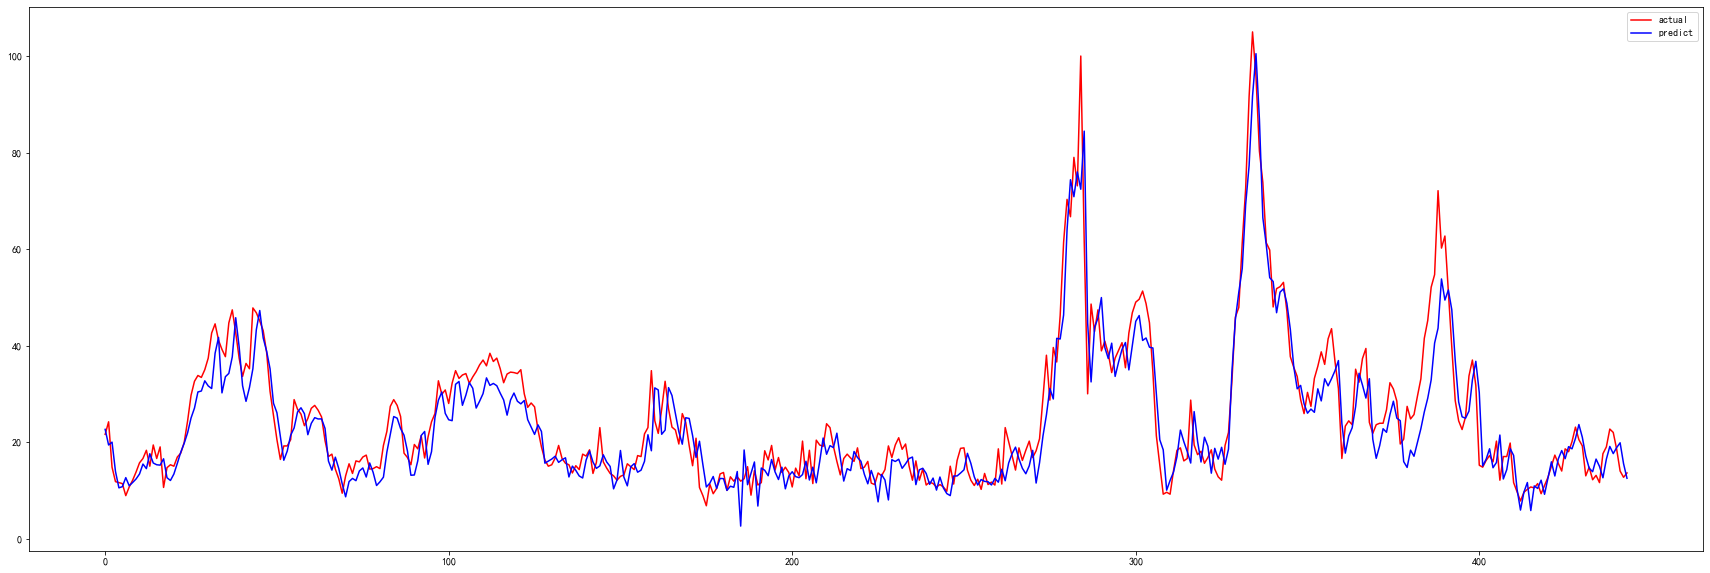

In [86]:
# 試用 加外生變數預測一天
df_exogs = df.drop(columns=['Upper_Price','Middle_Price','Avg_Price','Lower_Price','Trans_Quantity'])

window = 30
future_d = 5
output_d = 1
epo = 100
batch = 32
target_name = 'Middle_Price'
learning_rate = 0.001
with_exogs = multi_LSTM_exogs(df_train, df_test, df_exogs, window, future_d, output_d, epo, batch, target_name, use_valid=False, lr=learning_rate)

train_sc_x: 
(1045, 11)
train_sc_y: 
(1019, 1)
train shape: 
(1015, 30, 11) (1015, 5)
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
original_input (InputLayer)  [(None, 30, 11)]          0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 50)                12400     
_________________________________________________________________
dropout_26 (Dropout)         (None, 50)                0         
_________________________________________________________________
final_dense (Dense)          (None, 5)                 255       
Total params: 12,655
Trainable params: 12,655
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
32/32 [==============================] - 1s 6ms/step - loss: 0.0255
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0144
Epoch 

,MAE,MSE,RMSE,MAPE
1,3.863861,29.304930,5.413403,17.829665
2,4.764244,48.412723,6.957925,21.376636
3,5.786033,66.578671,8.159575,26.520397
4,6.333087,78.908835,8.883064,28.233105
5,6.643284,84.640082,9.200004,30.028535


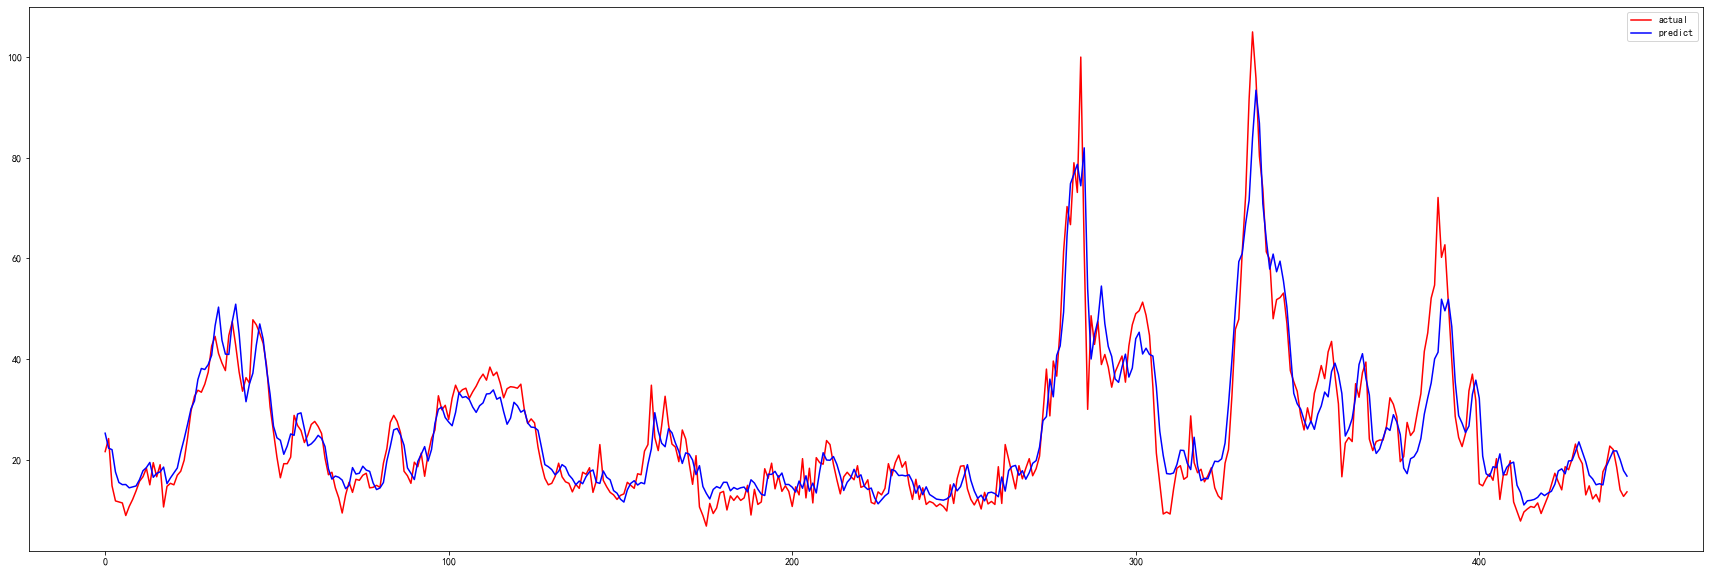

In [87]:
# 試用 不加入外生變數預測未來五天
df_exogs = df.drop(columns=['Upper_Price','Middle_Price','Avg_Price','Lower_Price','Trans_Quantity'])

window = 30
future_d = 0
output_d = 5
epo = 100
batch = 32
target_name = 'Middle_Price'
lr = 0.001
with_exogs = multi_LSTM_exogs(df_train, df_test, df_exogs, window, future_d, output_d, epo, batch, target_name, have_exogs = False)

### 外生變數包含真實交易量

In [88]:
df_exogs = df.drop(columns=['Upper_Price','Middle_Price','Avg_Price','Lower_Price'])
df_exogs

,Trans_Quantity,Temperature_n,Precp_n,Temperature_m,Precp_m,Temperature_s,Precp_s
0,6718.0,20.77,0.75,19.40,0.08,21.87,0.15
1,9143.0,20.45,3.20,20.00,0.33,22.33,0.00
2,8489.0,21.80,0.47,20.27,0.00,22.67,0.02
3,6457.0,21.03,0.00,20.50,0.00,22.78,0.00
4,7353.0,21.07,3.23,20.13,0.00,22.78,0.02
...,...,...,...,...,...,...,...
1488,4646.0,13.80,6.60,15.98,0.67,18.15,0.01
1489,4237.0,16.48,1.00,16.85,0.00,19.27,0.51
1490,5689.0,17.60,0.19,17.78,0.83,20.52,4.51
1491,4213.0,15.88,0.08,17.05,0.17,19.83,0.09


train_sc_x: 
(1045, 11)
train_sc_y: 
(1019, 1)
train shape: 
(1015, 30, 11) (1015, 5)
exogs original shape: 
(1015, 5, 7)
exogs concat shape: 
(1015, 35)
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
original_input (InputLayer)     [(None, 30, 11)]     0                                            
__________________________________________________________________________________________________
lstm_27 (LSTM)                  (None, 50)           12400       original_input[0][0]             
__________________________________________________________________________________________________
dropout_27 (Dropout)            (None, 50)           0           lstm_27[0][0]                    
__________________________________________________________________________________________________
exogs_input (InputLayer)        [(No

,MAE,MSE,RMSE,MAPE
1,3.367997,23.534428,4.851230,15.650394
2,4.431524,39.904828,6.317027,21.790209
3,5.284282,55.025569,7.417922,25.714867
4,5.760559,63.883613,7.992723,28.071845
5,6.090566,67.715384,8.228936,30.175466


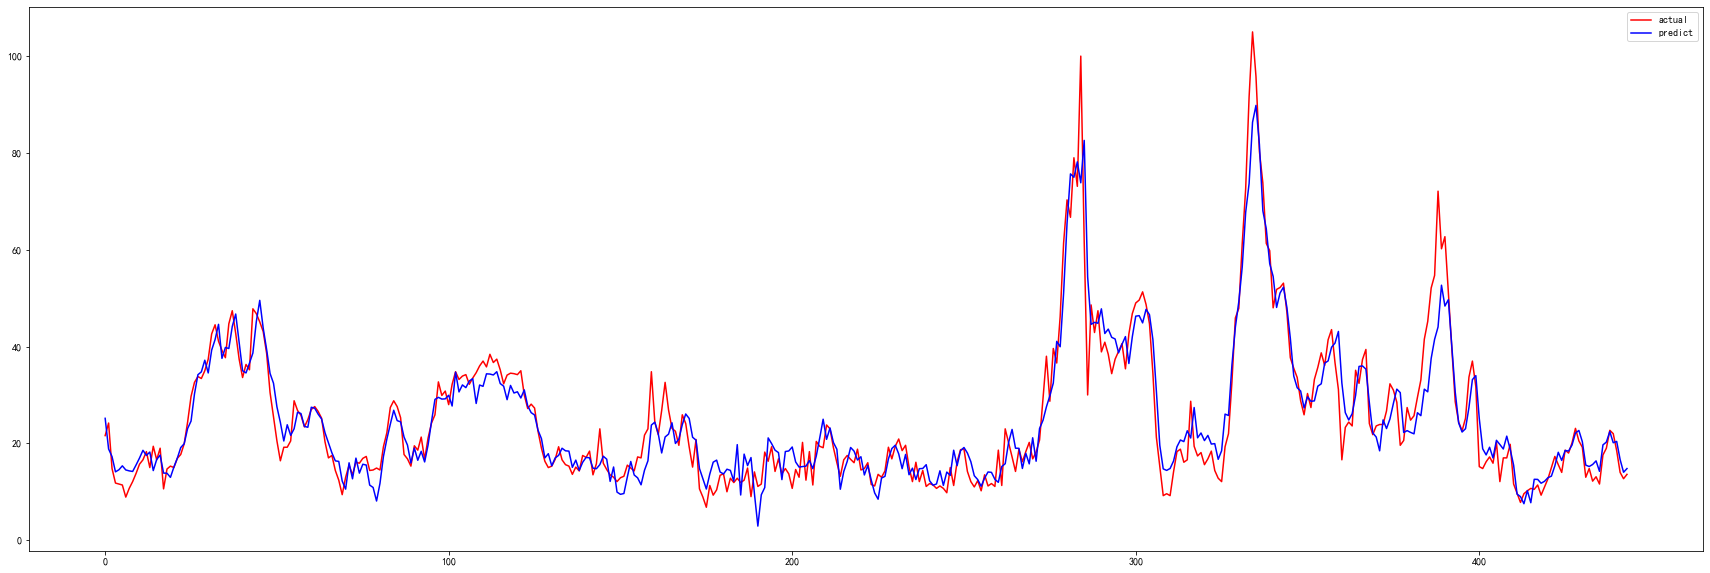

In [89]:
window = 30
future_d = 5
output_d = 5
epo = 100
batch = 32
target_name = 'Middle_Price'
with_exogs = multi_LSTM_exogs(df_train, df_test, df_exogs, window, future_d, output_d, epo, batch, target_name)

## LSTM one -> five (functional API)

只放一個變數前30天，預測未來5天<br>
單獨預測未來交易量<br>
（這邊就沒有寫成 function，用 multi_LSTM 裡面 dense 改成 5 也可以做到 -> 當然 test 算分那邊就要改成五天版本）<br>
這邊就只有 future_d 統一代表 外生變數、output的未來天數

In [90]:
window = 30
future_d = 5
epo = 100
batch = 32
target_name = 'Trans_Quantity'

In [91]:
# need to complete y_train and exogs_train with 5-1=4 instances from test set
# 或者是傳入 df_train_y 時處理好去掉前30天加上後5天
# 因為 train 要預測的最後一筆是 1045~1049, 1045 已有->只要多補4天
df_train_y = pd.concat((df_train[[target_name]][window:],df_test[[target_name]][:future_d-1]),axis=0)
df_train_y
# 現在 df_train_y 第0筆其實是第31天！！

,Trans_Quantity
30,4567.0
31,4775.0
32,5391.0
33,6154.0
34,3907.0
...,...
1044,4712.0
1045,5115.0
1046,6625.0
1047,9010.0


In [92]:
# scale x
sc = MinMaxScaler(feature_range=(0, 1))
df_train_sc = sc.fit_transform(df_train[[target_name]])
features = df_train_sc.shape[1]
print("train_sc_x: ")
print(df_train_sc.shape)

# scale y
sc2 = MinMaxScaler(feature_range=(0, 1))
df_train_sc_y = sc2.fit_transform(df_train_y)
print("train_sc_y: ")
print(df_train_sc_y.shape)

train_sc_x: 
(1045, 1)
train_sc_y: 
(1019, 1)


In [93]:
df_train_sc

array([[0.46146518],
       [0.69248357],
       [0.63018005],
       ...,
       [0.2960846 ],
       [0.34133562],
       [0.27036296]])

In [94]:
# process moving window
X_train = []
Y_train = []
for i in range(window,len(df_train)):
    X_train.append(df_train_sc[i-window:i])
for i in range(len(df_train)-window):
    Y_train.append(df_train_sc_y[i:i+future_d,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
print("train shape: ")
print(X_train.shape, Y_train.shape)

train shape: 
(1015, 30, 1) (1015, 5)


In [107]:
# LSTM model
set_rand()
input1 = Input(shape=(window,features,), name="input")
lstm_output = LSTM(units=50)(input1)
lstm_output = layers.Dropout(0.2)(lstm_output)
final_pred = Dense(future_d, name="final_dense")(lstm_output)
## create the model
model = Model(inputs=input1, outputs=final_pred)
model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 30, 1)]           0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dropout_30 (Dropout)         (None, 50)                0         
_________________________________________________________________
final_dense (Dense)          (None, 5)                 255       
Total params: 10,655
Trainable params: 10,655
Non-trainable params: 0
_________________________________________________________________


In [1115]:
# from keras.callbacks import EarlyStopping
# usualCallback = EarlyStopping()
# overfitCallback = EarlyStopping(monitor='loss', min_delta=0, patience = 20)

In [108]:
opt = Adam(learning_rate = 0.01)
es = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
mc = ModelCheckpoint('../iris/Model/best_trans_model_train.h5', monitor='loss', verbose=1, save_best_only=True) # 自行改儲存路徑，記得下面 load_model 要一樣
# callback = [early_stopping]

In [109]:
# 原始設定
model.compile(optimizer='adam',loss="mean_squared_error")
history = model.fit(X_train, Y_train, epochs=epo, batch_size=batch)

# 使用 adam optimizer, 並且 callbacks=mc 為上面定義好的儲存 training loss 最小的 model checkpoint
# model.compile(optimizer='adam',loss="mean_squared_error")
# history = model.fit(X_train, Y_train, epochs=epo, batch_size=batch, callbacks=[mc])

# 使用自定義 optimizer(上一格有定義，可調很多參數)，使用 validation set，callback 除了 mc 還加了 es(上面定義的 EarlyStopping，監測 validation loss，一樣有很多參數可調)
# model.compile(optimizer=opt, loss="mean_squared_error")
# history = model.fit(X_train, Y_train, validation_split=0.1, epochs=250, batch_size=batch, callbacks=[es, mc])
# plot_history(history)

saved_model = load_model('../iris/Model/best_trans_model_train.h5')

Epoch 1/100
32/32 [==============================] - 1s 5ms/step - loss: 0.0578
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0313
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0304
Epoch 4/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0289
Epoch 5/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0286
Epoch 6/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0282
Epoch 7/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0285
Epoch 8/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 9/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0269
Epoch 10/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0264
Epoch 11/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0265
Epoch 12/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0263
Epoch 13/100
32/32 [=================

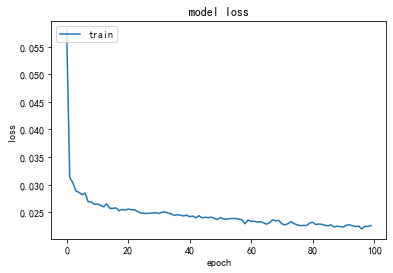

In [110]:
# 單獨畫出 train loss 的圖
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

### 先用後面的444當testing評估模型結果

In [117]:
# preprocess test set (x, exogs)
df_train_last = df_train[[target_name]][-1*window:]
full_test = pd.concat((df_train_last,df_test[[target_name]]),axis=0)
full_test = sc.transform(full_test)
print("full_test: ")
print(full_test.shape)

record_num = full_test.shape[0]
X_test = []
for i in range(window,record_num-future_d+1): #30,478
# +1 是因為不用扣滿5筆，最後5的第一個可以當預測第一天，且前面加了30筆導致最前面多一筆x
    X_test.append(full_test[i-window:i])
X_test = np.array(X_test)
print("x_test after window: ")
print(X_test.shape)

full_test: 
(478, 1)
x_test after window: 
(444, 30, 1)


In [112]:
# predict
Y_test = saved_model.predict(X_test)
Y_test.shape

(444, 5)

In [113]:
y_pred = sc2.inverse_transform(Y_test)
final_predict = pd.DataFrame(y_pred)
final_predict.columns=['predict_d1','predict_d2','predict_d3','predict_d4','predict_d5']
print("predict result: ")
print(final_predict)

predict result: 
      predict_d1   predict_d2   predict_d3   predict_d4    predict_d5
0    5511.773926  5277.503418  5912.519043  7378.670898   8017.180176
1    5942.070312  5677.860840  6337.916504  7902.011230   8537.748047
2    7051.011230  6505.578125  7021.073730  8503.923828   9117.532227
3    8808.612305  7719.434082  7981.049316  9296.617188   9889.583008
4    8741.998047  7675.962891  8146.950684  9623.627930  10280.098633
..           ...          ...          ...          ...           ...
439  5366.679688  5591.369141  5630.812988  5566.482422   5458.843262
440  5627.405273  5656.886719  5592.725586  5468.999023   5413.624512
441  5531.378418  5503.400391  5436.138184  5354.582520   5363.675781
442  5523.357910  5452.236328  5382.354492  5336.904785   5379.103027
443  5857.795410  5663.844727  5532.695801  5466.513672   5513.433594

[444 rows x 5 columns]


In [114]:
Y_true = []
for i in range(len(df_test)-future_d+1):
    Y_true.append(df_test[target_name][i:i+future_d])
Y_true = np.array(Y_true)
Y_true = Y_true.reshape(Y_true.shape[0],Y_true.shape[1])
print(Y_true.shape)
true = pd.DataFrame(Y_true)
true.columns=['true_d1','true_d2','true_d3','true_d4','true_d5']
print("true result: ")
print(true)

(444, 5)
true result: 
     true_d1  true_d2  true_d3  true_d4  true_d5
0     5115.0   6625.0   9010.0   8685.0   6723.0
1     6625.0   9010.0   8685.0   6723.0   5241.0
2     9010.0   8685.0   6723.0   5241.0   6058.0
3     8685.0   6723.0   5241.0   6058.0   5675.0
4     6723.0   5241.0   6058.0   5675.0   5703.0
..       ...      ...      ...      ...      ...
439   5526.0   5432.0   5555.0   6235.0   4646.0
440   5432.0   5555.0   6235.0   4646.0   4237.0
441   5555.0   6235.0   4646.0   4237.0   5689.0
442   6235.0   4646.0   4237.0   5689.0   4213.0
443   4646.0   4237.0   5689.0   4213.0   3871.0

[444 rows x 5 columns]


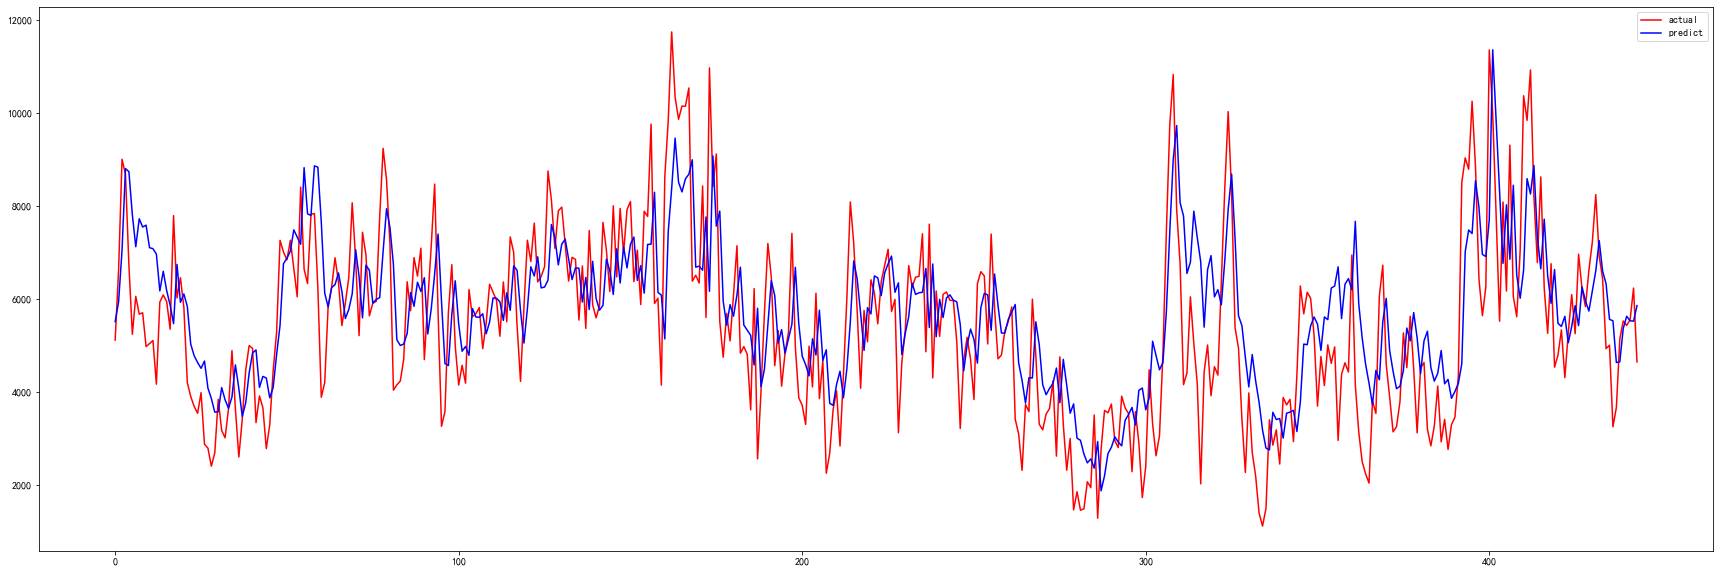

In [115]:
# plot the result of day1
plt.figure(figsize=(30,10))
plt.plot(true['true_d1'],label='actual',color='red')
plt.plot(final_predict['predict_d1'],label='predict',color='blue')
plt.legend()

In [116]:
# calculate metrics
metric_list = []

for i in range(1,future_d+1):
    mae = mean_absolute_error(true['true_d'+str(i)], final_predict['predict_d'+str(i)])
    mse = mean_squared_error(true['true_d'+str(i)], final_predict['predict_d'+str(i)])
    rmse = np.sqrt(mse)
    mape_result = mape(true['true_d'+str(i)], final_predict['predict_d'+str(i)])
    metric_list.append([mae, mse, rmse, mape_result])

metrics_df = pd.DataFrame(metric_list,index=range(1,future_d+1),columns=['MAE','MSE','RMSE','MAPE'])
print(metric_list)
metrics_df

[[1147.1519511454815, 2078798.0764212448, 1441.8037579439322, 26.15201850026655], [1381.3367364556939, 2997074.7848494826, 1731.206164744535, 32.428808393092375], [1576.8142243806305, 3928949.057066893, 1982.1576771455123, 37.818702842229186], [1767.4897262985642, 5231334.617021137, 2287.21110023127, 43.87608279624297], [1847.3928794517174, 5827790.594866187, 2414.0817291190015, 46.180351569889346]]


,MAE,MSE,RMSE,MAPE
1,1147.151951,2.078798e+06,1441.803758,26.152019
2,1381.336736,2.997075e+06,1731.206165,32.428808
3,1576.814224,3.928949e+06,1982.157677,37.818703
4,1767.489726,5.231335e+06,2287.211100,43.876083
5,1847.392879,5.827791e+06,2414.081729,46.180352


In [118]:
TRANS = final_predict.copy()
TRANS

,predict_d1,predict_d2,predict_d3,predict_d4,predict_d5
0,5511.773926,5277.503418,5912.519043,7378.670898,8017.180176
1,5942.070312,5677.860840,6337.916504,7902.011230,8537.748047
2,7051.011230,6505.578125,7021.073730,8503.923828,9117.532227
3,8808.612305,7719.434082,7981.049316,9296.617188,9889.583008
4,8741.998047,7675.962891,8146.950684,9623.627930,10280.098633
...,...,...,...,...,...
439,5366.679688,5591.369141,5630.812988,5566.482422,5458.843262
440,5627.405273,5656.886719,5592.725586,5468.999023,5413.624512
441,5531.378418,5503.400391,5436.138184,5354.582520,5363.675781
442,5523.357910,5452.236328,5382.354492,5336.904785,5379.103027


### 測試時用交易量預測結果加入為外生變數（訓練時用真實交易量）

In [119]:
df_exogs = df.drop(columns=['Upper_Price','Middle_Price','Avg_Price','Lower_Price','Trans_Quantity'])
df_exogs

,Temperature_n,Precp_n,Temperature_m,Precp_m,Temperature_s,Precp_s
0,20.77,0.75,19.40,0.08,21.87,0.15
1,20.45,3.20,20.00,0.33,22.33,0.00
2,21.80,0.47,20.27,0.00,22.67,0.02
3,21.03,0.00,20.50,0.00,22.78,0.00
4,21.07,3.23,20.13,0.00,22.78,0.02
...,...,...,...,...,...,...
1488,13.80,6.60,15.98,0.67,18.15,0.01
1489,16.48,1.00,16.85,0.00,19.27,0.51
1490,17.60,0.19,17.78,0.83,20.52,4.51
1491,15.88,0.08,17.05,0.17,19.83,0.09


In [120]:
df_trans = df[['Trans_Quantity']]
df_trans

,Trans_Quantity
0,6718.0
1,9143.0
2,8489.0
3,6457.0
4,7353.0
...,...
1488,4646.0
1489,4237.0
1490,5689.0
1491,4213.0


In [121]:
window = 30
future_d = 5
epo = 100
batch = 32

In [122]:
# need to complete y_train and exogs_train with 5-1=4 instances from test set
# 或者是傳入 df_train_y 時處理好去掉前30天加上後5天
# 因為 train 要預測的最後一筆是 1045~1049, 1045 已有->只要多補4天
df_train_y = pd.concat((df_train[['Middle_Price']][window:],df_test[['Middle_Price']][:future_d-1]),axis=0)
# 現在 df_train_y 第0筆其實是第31天！！

In [123]:
# scale x
sc = MinMaxScaler(feature_range=(0, 1))
df_train_sc = sc.fit_transform(df_train)
features = df_train_sc.shape[1]
print("train_sc_x: ")
print(df_train_sc.shape)

# scale y
sc2 = MinMaxScaler(feature_range=(0, 1))
df_train_sc_y = sc2.fit_transform(df_train_y)
print("train_sc_y: ")
print(df_train_sc_y.shape)

train_sc_x: 
(1045, 11)
train_sc_y: 
(1019, 1)


In [124]:
# process moving window
X_train = []
Y_train = []
for i in range(window,len(df_train)):
    X_train.append(df_train_sc[i-window:i])
for i in range(len(df_train)-window):
    Y_train.append(df_train_sc_y[i:i+future_d,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
print("train shape: ")
print(X_train.shape,Y_train.shape)

train shape: 
(1015, 30, 11) (1015, 5)


In [125]:
# # add trans_quantity prediction results as exogs
# trans_np = np.array(TRANS)
# print(trans_np.shape)
# trans_train = trans_np[:len(df_train)-window]
# print(trans_train.shape)
# sc_trans = MinMaxScaler(feature_range=(0, 1))
# trans_train_sc = sc_trans.fit_transform(trans_train)
# print(trans_train_sc)
# trans_train_sc = trans_train_sc.reshape(len(df_train)-window,future_d,1)
# print(trans_train_sc.shape)
# # print(trans_train_sc)

In [126]:
# process moving window for exogs
exogs_num = len(df_exogs.columns)+1
Exogs_train = []
# use new sc to fit and transform exogs
sc_exogs = MinMaxScaler(feature_range=(0, 1))
df_exogs_sc = sc_exogs.fit_transform(df_exogs[window:len(df_train)+future_d-1])

sc_trans = MinMaxScaler(feature_range=(0, 1))
df_trans_sc = sc_trans.fit_transform(df_trans[window:len(df_train)+future_d-1])
print(df_trans_sc.shape)

df_exogs_sc = np.concatenate((df_exogs_sc, df_trans_sc), axis=1)
print(df_exogs_sc.shape)

for i in range(len(df_train)-window):
    Exogs_train.append(df_exogs_sc[i:i+future_d])
Exogs_train = np.array(Exogs_train)
print("exogs original shape: ")
print(Exogs_train.shape)
# print(Exogs_train)

Exogs_train = Exogs_train.reshape(Exogs_train.shape[0],exogs_num*future_d)
print("exogs concat shape: ")
print(Exogs_train.shape)

(1019, 1)
(1019, 7)
exogs original shape: 
(1015, 5, 7)
exogs concat shape: 
(1015, 35)


In [127]:
# model training with exogs
set_rand()
## first LSTM model
input1 = Input(shape=(window,features,), name="original_input")
lstm_output = LSTM(units=50)(input1)
lstm_output = layers.Dropout(0.2)(lstm_output)
## intermidate input (exogs)
input2 = Input(shape=(exogs_num*future_d,), name="exogs_input")
## concat firt LSTM output & exogs
final_merged = layers.concatenate([lstm_output, input2])
final_pred = Dense(future_d, name="final_dense")(final_merged)
## create the model
model = Model(inputs=[input1, input2], outputs=final_pred)
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
original_input (InputLayer)     [(None, 30, 11)]     0                                            
__________________________________________________________________________________________________
lstm_31 (LSTM)                  (None, 50)           12400       original_input[0][0]             
__________________________________________________________________________________________________
dropout_31 (Dropout)            (None, 50)           0           lstm_31[0][0]                    
__________________________________________________________________________________________________
exogs_input (InputLayer)        [(None, 35)]         0                                            
___________________________________________________________________________________________

In [128]:
model.compile(optimizer='adam',loss="mean_squared_error")
model.fit([X_train, Exogs_train], Y_train, epochs=epo, batch_size=batch)

Epoch 1/100
32/32 [==============================] - 1s 6ms/step - loss: 0.1106
Epoch 2/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0347
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.0263
Epoch 4/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0227
Epoch 5/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0196
Epoch 6/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0166
Epoch 7/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0148
Epoch 8/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0131
Epoch 9/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0119
Epoch 10/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0114
Epoch 11/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0101
Epoch 12/100
32/32 [==============================] - 0s 6ms/step - loss: 0.0095
Epoch 13/100
32/32 [=================

In [129]:
# preprocess test set (x, exogs)
df_train_last = df_train[-1*window:]
full_test = pd.concat((df_train_last,df_test),axis=0)
full_test = sc.transform(full_test)
print("full_test: ")
print(full_test.shape)

record_num = full_test.shape[0]
X_test = []
for i in range(window,record_num-future_d+1): #30,478
# +1 是因為不用扣滿5筆，最後5的第一個可以當預測第一天，且前面加了30筆導致最前面多一筆x
    X_test.append(full_test[i-window:i])
X_test = np.array(X_test)
print("x_test after window: ")
print(X_test.shape)

# 測試這邊的外生變數會使用到剛剛預測出的未來交易量 TRANS
trans_test = np.array(TRANS)
# trans_test = trans_test[len(df_train)-window:]
trans_test_sc_list = []
for i in range(trans_test.shape[1]):
    tt = np.array(trans_test[:,i])
    tt = tt.reshape(-1,1)
    trans_test_sc = sc_trans.transform(tt)
    trans_test_sc_list.append(trans_test_sc)
trans_test_sc = np.array(trans_test_sc_list)
print("trans_test: ")
print(trans_test_sc.shape)
trans_test_sc = trans_test_sc.reshape(len(df_test)-future_d+1,future_d,1)
print("trans_test reshaped: ")
print(trans_test_sc.shape)

Exogs_test_data = df_exogs[len(df_train):]
print("exogs_test: ")
print(Exogs_test_data.shape)

Exogs_test_data = sc_exogs.transform(Exogs_test_data)


Exogs_test = []
for i in range(Exogs_test_data.shape[0]-future_d+1):
    Exogs_test.append(Exogs_test_data[i:i+future_d])
Exogs_test = np.array(Exogs_test)
print("exogs_test after window: ")
print(Exogs_test.shape)

merged_exogs_test = np.concatenate((Exogs_test, trans_test_sc), axis=2)
print("merged exogs test shape: ")
print(merged_exogs_test.shape)
# print(merged_exogs)

# concat (flatten)
Exogs_test = merged_exogs_test.reshape(merged_exogs_test.shape[0],exogs_num*future_d)
print("exogs concat test shape: ")
print(Exogs_test.shape)

full_test: 
(478, 11)
x_test after window: 
(444, 30, 11)
trans_test: 
(5, 444, 1)
trans_test reshaped: 
(444, 5, 1)
exogs_test: 
(448, 6)
exogs_test after window: 
(444, 5, 6)
merged exogs test shape: 
(444, 5, 7)
exogs concat test shape: 
(444, 35)


In [130]:
# predict
Y_test = model.predict([X_test, Exogs_test])
Y_test.shape

(444, 5)

In [131]:
y_pred = sc2.inverse_transform(Y_test)
final_predict = pd.DataFrame(y_pred)
final_predict.columns=['predict_d1','predict_d2','predict_d3','predict_d4','predict_d5']
print("predict result: ")
print(final_predict)

predict result: 
     predict_d1  predict_d2  predict_d3  predict_d4  predict_d5
0     25.275867   26.724493   23.320906   18.914505   16.437248
1     18.594692   19.338350   17.906052   16.286867   16.633278
2     18.659235   18.944464   19.274475   19.520254   20.261530
3     15.689897   18.446024   19.706295   19.916292   21.825335
4     14.509953   16.222876   17.733006   21.576002   23.916878
..          ...         ...         ...         ...         ...
439   18.150047   21.746624   17.476267   17.511282   19.080496
440   20.978184   20.530331   18.762245   18.594856   20.333401
441   18.784513   16.316818   16.783360   16.826857   17.633844
442   14.145719   15.035012   16.610409   16.450165   16.519358
443   12.781794   17.041866   17.231619   18.634527   17.188284

[444 rows x 5 columns]


In [132]:
Y_true = []
for i in range(len(df_test)-future_d+1):
    Y_true.append(df_test['Middle_Price'][i:i+future_d])
Y_true = np.array(Y_true)
print(Y_true.shape)
true = pd.DataFrame(Y_true)
true.columns=['true_d1','true_d2','true_d3','true_d4','true_d5']
print("true result: ")
print(true)

(444, 5)
true result: 
     true_d1  true_d2  true_d3  true_d4  true_d5
0       21.6     24.2     14.8     11.8     11.6
1       24.2     14.8     11.8     11.6     11.4
2       14.8     11.8     11.6     11.4      8.9
3       11.8     11.6     11.4      8.9     10.7
4       11.6     11.4      8.9     10.7     12.1
..       ...      ...      ...      ...      ...
439     22.0     18.5     14.0     12.7     13.6
440     18.5     14.0     12.7     13.6     18.8
441     14.0     12.7     13.6     18.8     14.4
442     12.7     13.6     18.8     14.4     20.9
443     13.6     18.8     14.4     20.9     17.0

[444 rows x 5 columns]


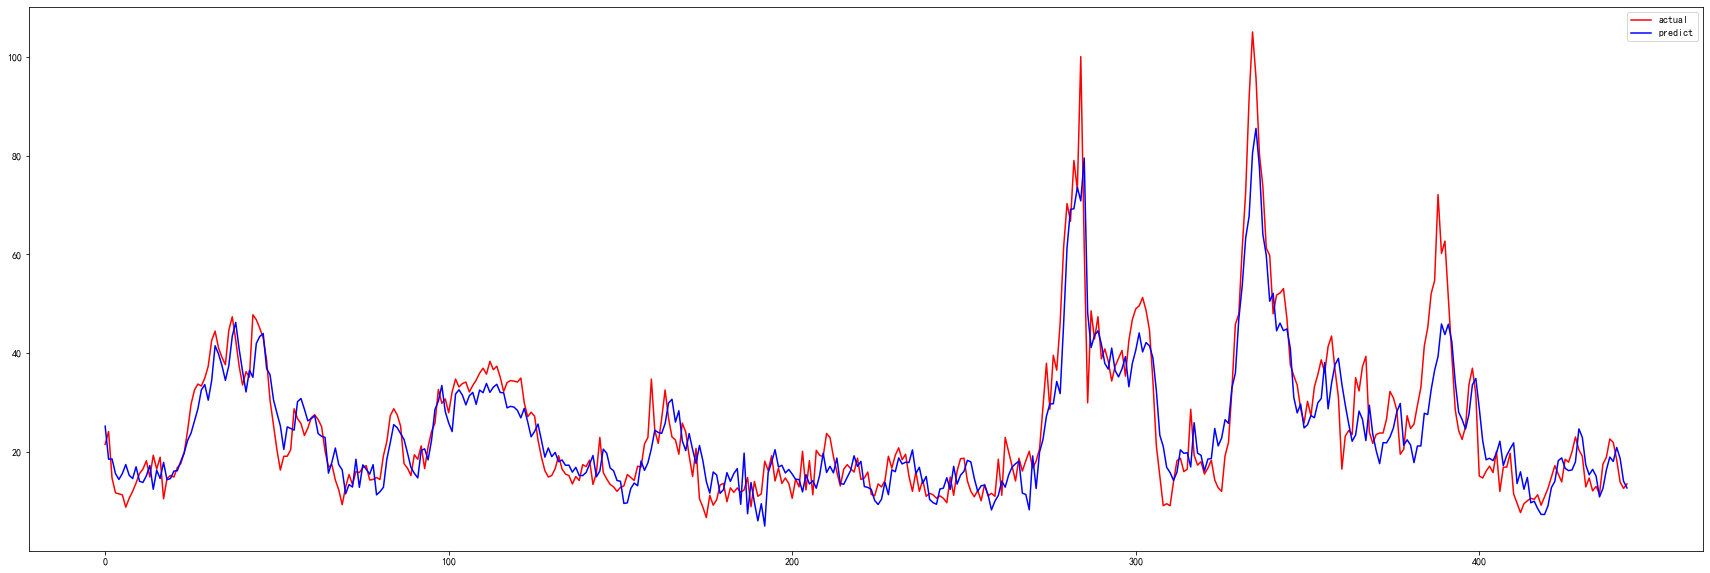

In [133]:
# plot the result of day1
plt.figure(figsize=(30,10))
plt.plot(true['true_d1'],label='actual',color='red')
plt.plot(final_predict['predict_d1'],label='predict',color='blue')
plt.legend()

In [134]:
# calculate metrics
metric_list = []

for i in range(1,future_d+1):
    mae = mean_absolute_error(true['true_d'+str(i)], final_predict['predict_d'+str(i)])
    mse = mean_squared_error(true['true_d'+str(i)], final_predict['predict_d'+str(i)])
    rmse = np.sqrt(mse)
    mape_result = mape(true['true_d'+str(i)], final_predict['predict_d'+str(i)])
    metric_list.append([mae, mse, rmse, mape_result])

metrics_df = pd.DataFrame(metric_list,index=range(1,future_d+1),columns=['MAE','MSE','RMSE','MAPE'])
print(metric_list)
metrics_df.style

[[4.52601469443725, 38.18792772055181, 6.179638154499972, 20.88841056994041], [5.402116771861239, 58.90442674807752, 7.67492193758852, 26.234246373858017], [6.867532337463654, 89.929639777839, 9.483123946139216, 33.02150965474911], [7.860018295962531, 114.12638514100823, 10.68299513905198, 36.900398387739756], [8.495366182091, 129.67296677291142, 11.387403864486032, 40.05466974127758]]


,MAE,MSE,RMSE,MAPE
1,4.526015,38.187928,6.179638,20.888411
2,5.402117,58.904427,7.674922,26.234246
3,6.867532,89.929640,9.483124,33.021510
4,7.860018,114.126385,10.682995,36.900398
5,8.495366,129.672967,11.387404,40.054670


## Use model to predict

In [183]:
### 將訓練好的模型拿來預測 ###
# model: 模型
# sc: x 的 scaler
# sc2: y 的 scaler
# df_acrop: df_train 切好的訓練資料(因為要把後30筆加進來)
# df_test: df_test 切好的測試資料

def model_predict(model, sc, sc2, df_acrop, df_test):
    # process test set (x)
    df_train_last = df_acrop[-1*window:]
    full_test = pd.concat((df_train_last,df_test),axis=0)
    full_test = sc.transform(full_test)
    print("full_test: ")
    print(full_test.shape)
    
    record_num = full_test.shape[0]
    X_test = []
    for i in range(window,record_num): #30,523
        X_test.append(full_test[i-window:i])
    X_test = np.array(X_test)
    print("test after window: ")
    print(X_test.shape)
    
    # predict
    Y_test = model.predict(X_test)
    print("predict: ")
    print(Y_test.shape)
    y_pred = sc2.inverse_transform(Y_test)
    final_predict = pd.DataFrame(y_pred)
    final_predict.columns=['predict']
    print("predict result: ")
    print(final_predict)
    final_predict.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    match = pd.concat((final_predict,df_test),axis=1)
    
    # plot the result
    plt.figure(figsize=(30,10))
    plt.plot(match['Middle_Price'],label='actual',color='red')
    plt.plot(match['predict'],label='predict',color='blue')
    plt.legend(prop={'size': 15})
    
    # metrics
    # calculate MAE
    mae = mean_absolute_error(match['Middle_Price'], match['predict'])
    # calculate MSE
    mse = mean_squared_error(match['Middle_Price'], match['predict'])
    rmse = np.sqrt(mse)

    # display
    print("Mean absolute error : " + str(mae))
    print("Mean squared error : " + str(mse))
    print("Root Mean squared error : " + str(rmse))
    print("Mean Absolute Percentage Error : " + str(mape(match['Middle_Price'],match['predict'])))
    
    return model

## Multi LSTM for all veg

In [175]:
### 使用多種蔬菜一起訓練 ###

def multi_LSTM_all(veg_num, train_len, df_train, df_acrop, df_test, window, epo, batch):
    # normalization
    sc = MinMaxScaler(feature_range=(0, 1))
    df_train_sc = sc.fit_transform(df_train)
    features = df_train_sc.shape[1]
    print("train_sc: ")
    print(df_train_sc.shape)
    sc2 = MinMaxScaler(feature_range=(0, 1))
    df_train_sc_y = sc2.fit_transform(df_train[['Middle_Price']])
    print("test_sc: ")
    print(df_train_sc_y.shape)
    
    # process moving window
    X_train = []
    Y_train = []
    
    veg_cnt = 0
    for veg in range(veg_num):
        veg_cnt = veg*train_len 
        print(veg_cnt)
        for i in range(window+veg_cnt,train_len+veg_cnt):
            X_train.append(df_train_sc[i-window:i])
            Y_train.append(df_train_sc_y[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
    print("train shape: ")
    print(X_train.shape,Y_train.shape)
    
    # training
    model = Sequential()
#     model.add(LSTM(units=50,return_sequences=True,input_shape=(window,features))) #(30d,6features)
#     model.add(Dropout(0.2))
    model.add(LSTM(units=50,input_shape=(window,features)))
    model.add(Dropout(0.2))
#     model.add(Dense(24))
    model.add(Dense(1))
    model.compile(optimizer='adam',loss="mean_squared_error")
    model.summary()
    model.fit(X_train,Y_train,epochs=epo,batch_size=batch)
    
    # process test set (x)
    df_train_last = df_acrop[-1*window:]
    full_test = pd.concat((df_train_last,df_test),axis=0)
    full_test = sc.transform(full_test)
    print("full_test: ")
    print(full_test.shape)
    
    record_num = full_test.shape[0]
    X_test = []
    for i in range(window,record_num): #30,523
        X_test.append(full_test[i-window:i])
    X_test = np.array(X_test)
    print("test after window: ")
    print(X_test.shape)
    
    # predict
    Y_test = model.predict(X_test)
    print("predict: ")
    print(Y_test.shape)
    y_pred = sc2.inverse_transform(Y_test)
    final_predict = pd.DataFrame(y_pred)
    final_predict.columns=['predict']
    print("predict result: ")
    print(final_predict)
    final_predict.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    match = pd.concat((final_predict,df_test),axis=1)
    
    # plot the result
    plt.figure(figsize=(30,10))
    plt.plot(match['Middle_Price'],label='actual',color='red')
    plt.plot(match['predict'],label='predict',color='blue')
    plt.legend()
    
    # metrics
    # calculate MAE
    mae = mean_absolute_error(match['Middle_Price'], match['predict'])
    # calculate MSE
    mse = mean_squared_error(match['Middle_Price'], match['predict'])
    rmse = np.sqrt(mse)

    # display
    print("Mean absolute error : " + str(mae))
    print("Mean squared error : " + str(mse))
    print("Root Mean squared error : " + str(rmse))
    print("Mean Absolute Percentage Error : " + str(mape(match['Middle_Price'],match['predict'])))
    
    return model, sc, sc2

## Multi LSTM for STL

In [176]:
 def multi_LSTM_STL(df_train, df_test, window, features, epo, batch):
    # normalization
    df_train_x = df_train.drop(columns=['Middle_Price'])
#     df_acrop = df_acrop.drop(columns=['Middle_Price'])
    
    sc = MinMaxScaler(feature_range=(0, 1))
    df_train_sc = sc.fit_transform(df_train_x)
    features = df_train_sc.shape[1]
    print("train_sc: ")
    print(df_train_sc.shape)
    sc2 = MinMaxScaler(feature_range=(0, 1))
    df_train_sc_y = sc2.fit_transform(df_train[['Middle_Price']])
    print("test_sc: ")
    print(df_train_sc_y.shape)
    
    # process moving window
    X_train = []
    Y_train = []
    for i in range(window,len(df_train)):
        X_train.append(df_train_sc[i-window:i])
        Y_train.append(df_train_sc_y[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
    print("train shape: ")
    print(X_train.shape,Y_train.shape)
    
    # training
    model = Sequential()
#     model.add(LSTM(units=50,return_sequences=True,input_shape=(window,features))) #(30d,6features)
#     model.add(Dropout(0.2))
    model.add(LSTM(units=50,input_shape=(window,features)))
    model.add(Dropout(0.2))
    model.add(Dense(24))
    model.add(Dense(1))
    model.compile(optimizer='adam',loss="mean_squared_error")
    model.summary()
    model.fit(X_train,Y_train,epochs=epo,batch_size=batch)
    
#     def fit():
#         result = model.fit(X_train,Y_train,epochs=epo,batch_size=batch)
#         return result
    
    # process test set (x)
    df_train_last = df_train_x[-1*window:]
    df_test_x = df_test.drop(columns=['Middle_Price'])
    full_test = pd.concat((df_train_last,df_test_x),axis=0)
    if isinstance(full_test, pd.Series):
        full_test = full_test.values.reshape(-1,1)
    full_test = sc.transform(full_test)
    print("full_test: ")
    print(full_test.shape)
    
    record_num = full_test.shape[0]
    X_test = []
    for i in range(window,record_num): #30,523
        X_test.append(full_test[i-window:i])
    X_test = np.array(X_test)
    print("test after window: ")
    print(X_test.shape)
    
    # predict
    Y_test = model.predict(X_test)
    print("predict: ")
    print(Y_test.shape)
    y_pred = sc2.inverse_transform(Y_test)
    final_predict = pd.DataFrame(y_pred)
    final_predict.columns=['predict']
    print("predict result: ")
    print(final_predict)
    final_predict.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    match = pd.concat((final_predict,df_test),axis=1)
    
    # plot the result
    plt.figure(figsize=(30,10))
    plt.plot(match['Middle_Price'],label='actual',color='red')
    plt.plot(match['predict'],label='predict',color='blue')
    plt.legend()
    
    # metrics
    # calculate MAE
    mae = mean_absolute_error(match['Middle_Price'], match['predict'])
    # calculate MSE
    mse = mean_squared_error(match['Middle_Price'], match['predict'])
    rmse = np.sqrt(mse)

    # display
    print("Mean absolute error : " + str(mae))
    print("Mean squared error : " + str(mse))
    print("Root Mean squared error : " + str(rmse))
    print("Mean Absolute Percentage Error : " + str(mape(match['Middle_Price'],match['predict'])))
    
    return model, sc, sc2

# 不同蔬菜一起train，都只放七成作為training

In [150]:
# wea_filename = "C0K520雲林東勢.csv" #七成都是1045筆
d = {"LB1":"小白菜_台北一.csv", "LC1":"包心白_台北一.csv", "LI3":"萵苣菜_台北一.csv", "LD1":"青江白菜_台北一.csv", "LN1":"油菜_台北一.csv"}
df_all = pd.DataFrame(columns=['Upper_Price','Middle_Price','Lower_Price','Avg_Price','Trans_Quantity','Temperature_n','Precp_n','Temperature_m','Precp_m','Temperature_s','Precp_s'])

for key in d:
    print(key)
    df1 = newMergeData(d[key], key, False)
    print(len(df1))
    df_all = pd.concat([df1[:int(len(df1)*0.7)], df_all], ignore_index=True)

df_all

LB1
1493
LC1
1493
LI3
1493
LD1
1493
LN1
1493


,Upper_Price,Middle_Price,Lower_Price,Avg_Price,Trans_Quantity,Temperature_n,Precp_n,Temperature_m,Precp_m,Temperature_s,Precp_s
0,14.8,7.8,3.6,8.4,9872.0,20.77,0.75,19.40,0.08,21.87,0.15
1,18.2,12.8,7.4,12.8,10945.0,20.45,3.20,20.00,0.33,22.33,0.00
2,15.6,11.4,7.5,11.5,10017.0,21.80,0.47,20.27,0.00,22.67,0.02
3,16.7,9.2,3.7,9.6,13196.0,21.03,0.00,20.50,0.00,22.78,0.00
4,16.2,8.4,4.5,9.2,11468.0,21.07,3.23,20.13,0.00,22.78,0.02
...,...,...,...,...,...,...,...,...,...,...,...
5220,40.4,32.5,20.4,31.7,5080.0,30.58,0.00,29.08,0.00,30.53,0.00
5221,50.0,33.3,18.9,33.8,4450.0,30.37,0.00,29.13,0.00,30.40,0.00
5222,38.4,30.8,19.2,30.0,4982.0,30.53,0.00,28.63,1.01,29.93,0.25
5223,37.0,28.0,18.3,27.9,5457.0,30.97,0.00,29.27,0.00,30.18,0.28


下面是用這個多種蔬菜訓練的模型，對不同蔬菜做 testing

## 小白菜 LB1

In [206]:
testing = newMergeData("小白菜_台北一.csv", "LB1", False)
ntrain = int(len(testing)*0.7)
acrop_train = testing[:ntrain]
acrop_test = testing[ntrain:]
print(ntrain)

1045


train_sc: 
(5225, 11)
test_sc: 
(5225, 1)
0
1045
2090
3135
4180
train shape: 
(5075, 30, 11) (5075,)
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 50)                12400     
_________________________________________________________________
dropout_38 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 51        
Total params: 12,451
Trainable params: 12,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
159/159 [==============================] - 2s 6ms/step - loss: 0.0107
Epoch 2/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0037
Epoch 3/100
159/159 [==============================] - 1s 5ms/step - loss: 0.0030
Epoch 4/100
159/159 [===========

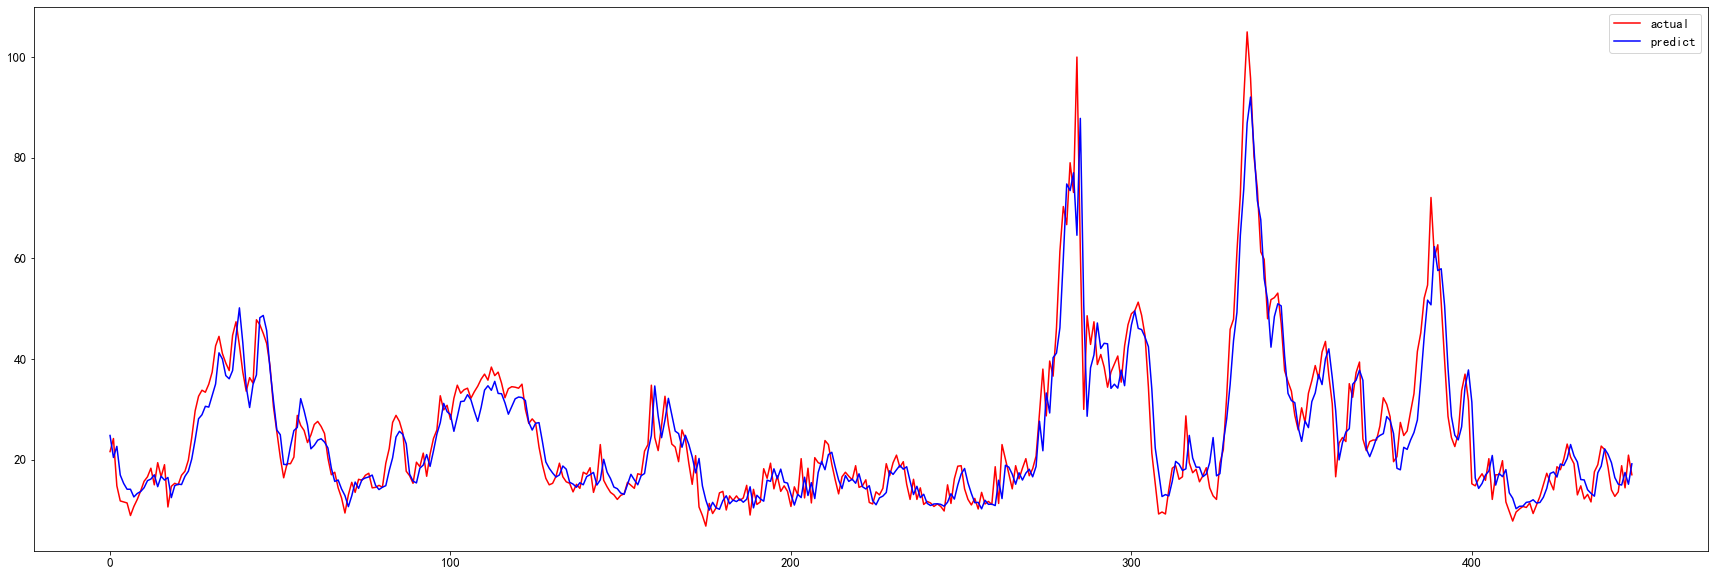

In [207]:
window = 30
epo = 100
batch = 32
# 這裡先 train & test
result, sc_x, sc_y = multi_LSTM_all(5, ntrain, df_all, acrop_train, acrop_test, window, epo, batch)

## 包心白 LC1

In [208]:
testing1 = newMergeData("包心白_台北一.csv", "LC1", False)
acrop_train1 = testing1[:ntrain]
acrop_test1 = testing1[ntrain:]

full_test: 
(478, 11)
test after window: 
(448, 30, 11)
predict: 
(448, 1)
predict result: 
       predict
0    15.711726
1    16.517937
2    11.818989
3    11.253871
4    11.857805
..         ...
443  11.960405
444  11.533885
445  13.477099
446  13.893813
447  12.198268

[448 rows x 1 columns]
Mean absolute error : 2.9018683433532715
Mean squared error : 18.838902629196944
Root Mean squared error : 4.3403804705575
Mean Absolute Percentage Error : 16.009337400463178


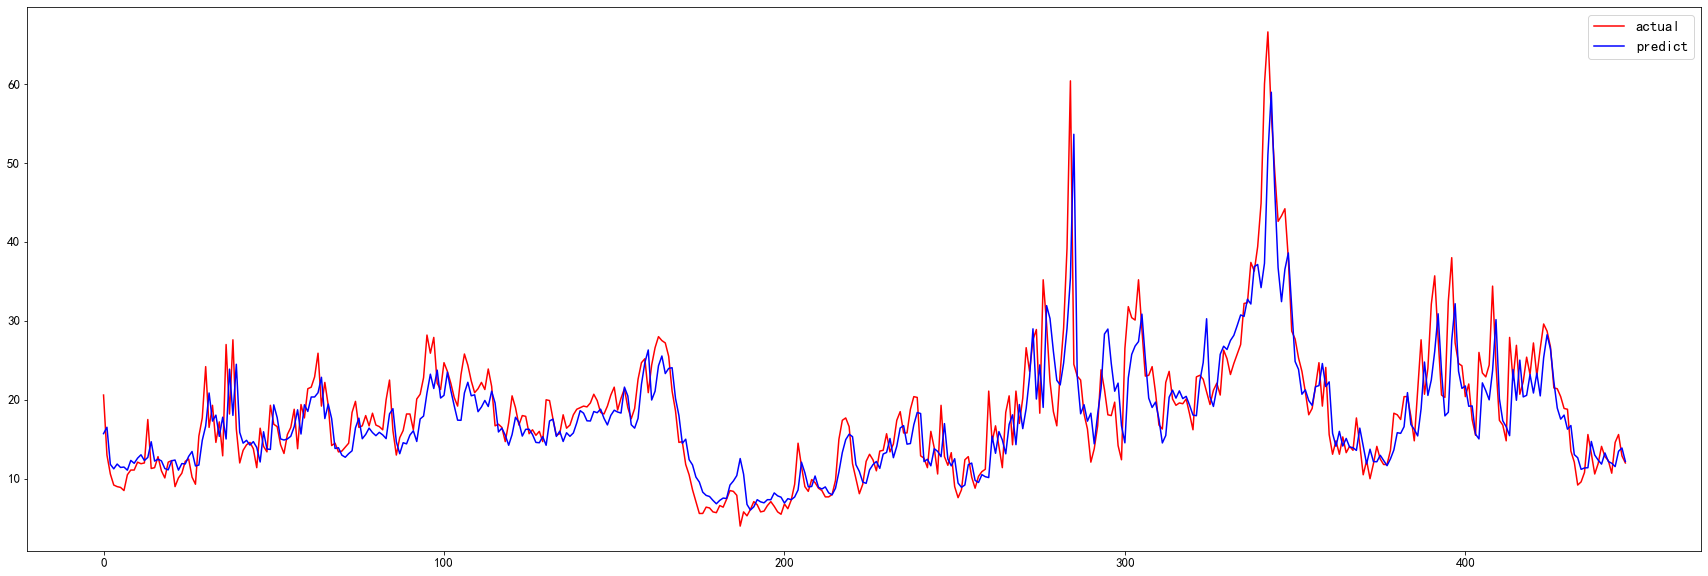

In [209]:
# 用小白菜那邊訓練好的多蔬菜模型來預測
predict_result = model_predict(result, sc_x, sc_y, acrop_train1, acrop_test1)

## 油菜 LN1

In [210]:
testing2 = newMergeData("油菜_台北一.csv","LN1", False)
acrop_train2 = testing2[:ntrain]
acrop_test2 = testing2[ntrain:]

full_test: 
(478, 11)
test after window: 
(448, 30, 11)
predict: 
(448, 1)
predict result: 
       predict
0    18.616545
1    16.441998
2    19.163477
3    14.213026
4    11.988730
..         ...
443  20.174828
444  19.038357
445  23.501545
446  20.702660
447  13.765816

[448 rows x 1 columns]
Mean absolute error : 3.050368242391518
Mean squared error : 19.268995647793467
Root Mean squared error : 4.389646414894196
Mean Absolute Percentage Error : 15.611782424462305


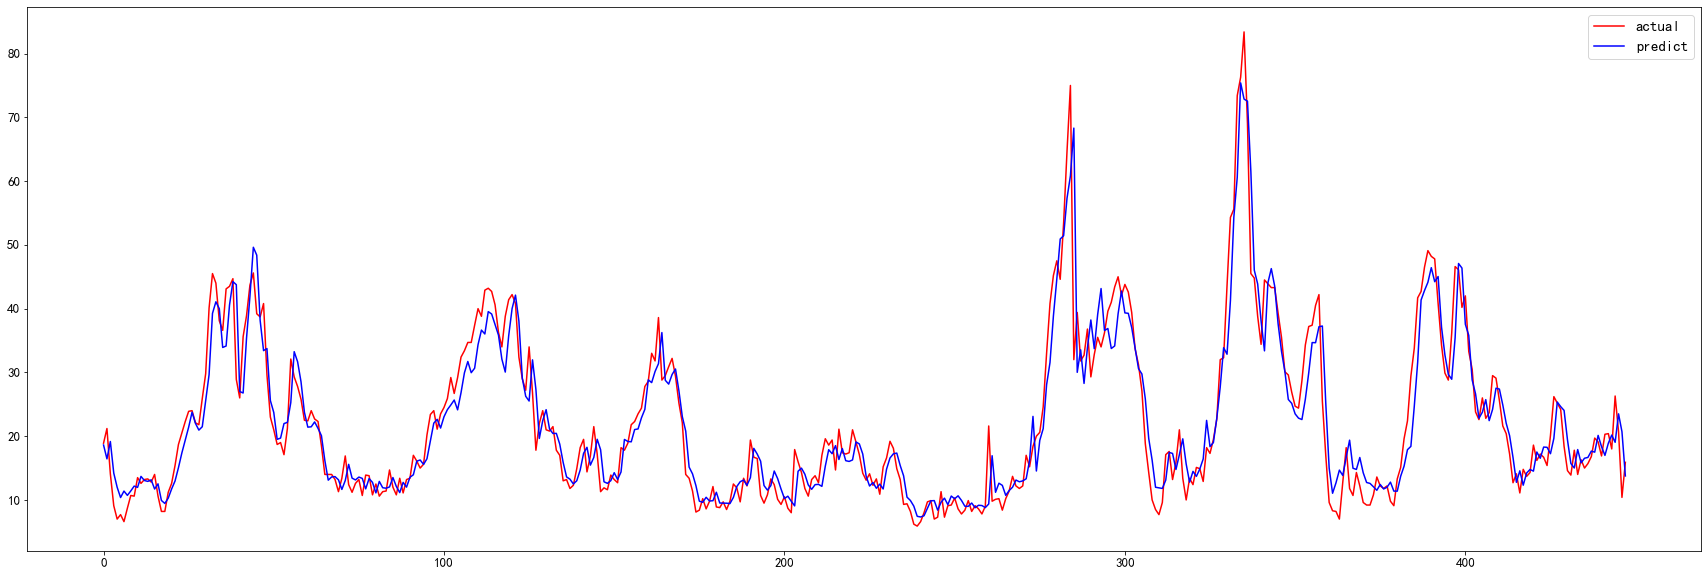

In [211]:
predict_result_LN1 = model_predict(result, sc_x, sc_y, acrop_train2, acrop_test2)

## 萵苣菜 LI3

In [212]:
testing3 = newMergeData("萵苣菜_台北一.csv","LI3", False)
acrop_train3 = testing3[:ntrain]
acrop_test3 = testing3[ntrain:]

full_test: 
(478, 11)
test after window: 
(448, 30, 11)
predict: 
(448, 1)
predict result: 
       predict
0    22.540977
1    28.127769
2    28.434513
3    24.188782
4    31.408712
..         ...
443  29.652851
444  29.391840
445  29.544273
446  29.017460
447  26.418615

[448 rows x 1 columns]
Mean absolute error : 4.508250171371868
Mean squared error : 39.09388964317164
Root Mean squared error : 6.2525106671777575
Mean Absolute Percentage Error : 12.167090539104953


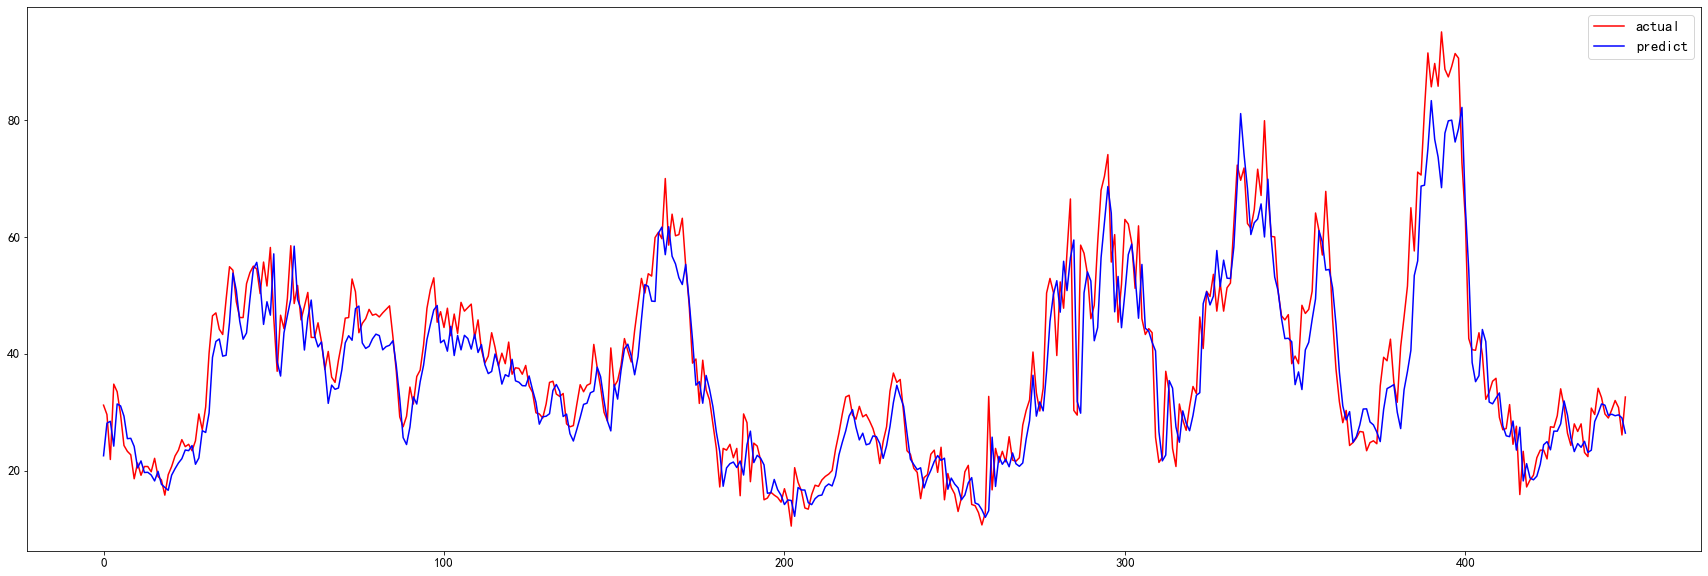

In [213]:
predict_result_LI3 = model_predict(result, sc_x, sc_y, acrop_train3, acrop_test3)

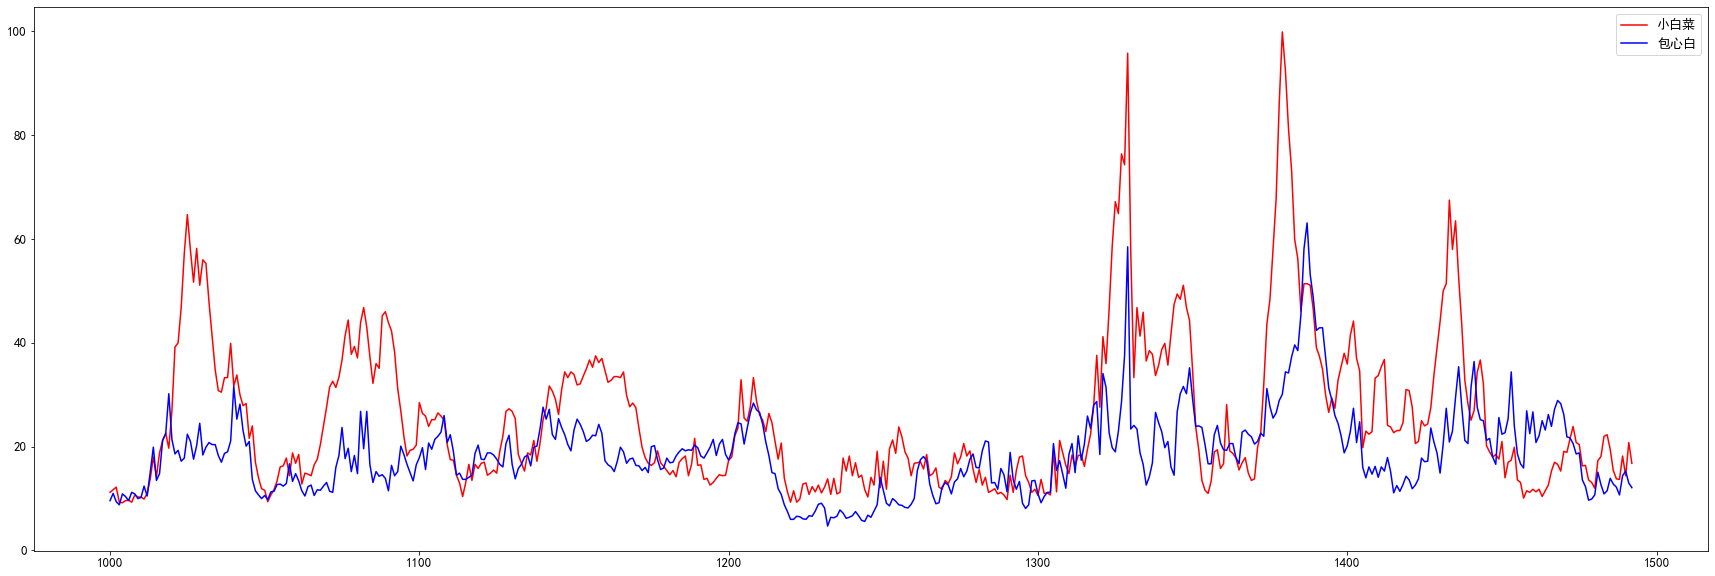

In [214]:
# 畫出小白菜、包心白的均價圖
plt.close()
plt.figure(figsize=(30,10))
plt.plot(testing['Avg_Price'][1000:],label='小白菜',color='red')
plt.plot(testing1['Avg_Price'][1000:],label='包心白',color='blue')
plt.legend()

In [ ]:
testing